In [1]:
from __future__ import absolute_import, division, print_function

import logging
import argparse
import os
import random
import numpy as np
import ml_collections
import copy
import math
from os.path import join as pjoin

from datetime import timedelta

import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
from torch.nn.modules.utils import _pair
from scipy import ndimage

from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

from utils.scheduler import WarmupLinearSchedule, WarmupCosineSchedule
from utils.data_utils import get_loader
from utils.dist_util import get_world_size

In [2]:
logger = logging.getLogger(__name__)

In [3]:
parser = argparse.ArgumentParser()
# Required parameters
parser.add_argument("--name", type=str, default="cifar10-100_500",
                    help="Name of this run. Used for monitoring.")
parser.add_argument("--dataset", choices=["cifar10", "cifar100"], default="cifar10",
                    help="Which downstream task.")
parser.add_argument("--model_type", choices=["ViT-B_16", "ViT-B_32", "ViT-L_16",
                                             "ViT-L_32", "ViT-H_14", "R50-ViT-B_16"],
                    default="ViT-B_16",
                    help="Which variant to use.")
parser.add_argument("--pretrained_dir", type=str, default="checkpoint/ViT-B_16.npz",
                    help="Where to search for pretrained ViT models.")
parser.add_argument("--output_dir", default="output", type=str,
                    help="The output directory where checkpoints will be written.")

parser.add_argument("--img_size", default=224, type=int,
                    help="Resolution size")
parser.add_argument("--train_batch_size", default=64, type=int,
                    help="Total batch size for training.")
parser.add_argument("--eval_batch_size", default=64, type=int,
                    help="Total batch size for eval.")
parser.add_argument("--eval_every", default=100, type=int,
                    help="Run prediction on validation set every so many steps."
                         "Will always run one evaluation at the end of training.")

parser.add_argument("--learning_rate", default=3e-2, type=float,
                    help="The initial learning rate for SGD.")
parser.add_argument("--weight_decay", default=0, type=float,
                    help="Weight deay if we apply some.")
parser.add_argument("--num_steps", default=10000, type=int,
                    help="Total number of training epochs to perform.")
parser.add_argument("--decay_type", choices=["cosine", "linear"], default="cosine",
                    help="How to decay the learning rate.")
parser.add_argument("--warmup_steps", default=500, type=int,
                    help="Step of training to perform learning rate warmup for.")
parser.add_argument("--max_grad_norm", default=1.0, type=float,
                    help="Max gradient norm.")

parser.add_argument("--local_rank", type=int, default=-1,
                    help="local_rank for distributed training on gpus")
parser.add_argument('--seed', type=int, default=42,
                    help="random seed for initialization")
parser.add_argument('--gradient_accumulation_steps', type=int, default=1,
                    help="Number of updates steps to accumulate before performing a backward/update pass.")
parser.add_argument('--fp16', action='store_true',
                    help="Whether to use 16-bit float precision instead of 32-bit")
parser.add_argument('--fp16_opt_level', type=str, default='O2',
                    help="For fp16: Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']."
                         "See details at https://nvidia.github.io/apex/amp.html")
parser.add_argument('--loss_scale', type=float, default=0,
                    help="Loss scaling to improve fp16 numeric stability. Only used when fp16 set to True.\n"
                         "0 (default value): dynamic loss scaling.\n"
                         "Positive power of 2: static loss scaling value.\n")
args = parser.parse_args(args = [])

In [4]:
# Setup CUDA, GPU & distributed training
if args.local_rank == -1:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    args.n_gpu = torch.cuda.device_count()
else:  # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.cuda.set_device(args.local_rank)
    device = torch.device("cuda", args.local_rank)
    torch.distributed.init_process_group(backend='nccl',
                                         timeout=timedelta(minutes=60))
    args.n_gpu = 1
args.device = device

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def simple_accuracy(preds, labels):
    return (preds == labels).mean()

In [7]:
def save_model(args, model):
    model_to_save = model.module if hasattr(model, 'module') else model
    model_checkpoint = os.path.join(args.output_dir, "%s_checkpoint_ivit_ali_mmd.bin" % args.name)
    torch.save(model_to_save.state_dict(), model_checkpoint)
    logger.info("Saved model checkpoint to [DIR: %s]", args.output_dir)

In [8]:
def get_b16_config():
    """Returns the ViT-B/16 configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 768
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 3072
    config.transformer.num_heads = 12
    config.transformer.num_layers = 12
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    config.classifier = 'token'
    config.representation_size = None
    return config

In [9]:
config = get_b16_config()

In [10]:
ATTENTION_Q = "MultiHeadDotProductAttention_1/query"
ATTENTION_K = "MultiHeadDotProductAttention_1/key"
ATTENTION_V = "MultiHeadDotProductAttention_1/value"
ATTENTION_OUT = "MultiHeadDotProductAttention_1/out"
FC_0 = "MlpBlock_3/Dense_0"
FC_1 = "MlpBlock_3/Dense_1"
ATTENTION_NORM = "LayerNorm_0"
MLP_NORM = "LayerNorm_2"

def np2th(weights, conv=False):
    """Possibly convert HWIO to OIHW."""
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)

def swish(x):
    return x * torch.sigmoid(x)

ACT2FN = {"gelu": torch.nn.functional.gelu, "relu": torch.nn.functional.relu, "swish": swish}

In [11]:
class Attention(nn.Module):
    def __init__(self, config, vis):
        super(Attention, self).__init__()
        self.vis = vis
        self.num_attention_heads = config.transformer["num_heads"]
        self.attention_head_size = int(config.hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = Linear(config.hidden_size, self.all_head_size)
        self.key = Linear(config.hidden_size, self.all_head_size)
        self.value = Linear(config.hidden_size, self.all_head_size)

        self.out = Linear(config.hidden_size, config.hidden_size)
        self.attn_dropout = Dropout(config.transformer["attention_dropout_rate"])
        self.proj_dropout = Dropout(config.transformer["attention_dropout_rate"])

        self.softmax = Softmax(dim=-1)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights

In [12]:
class Mlp(nn.Module):
    def __init__(self, config):
        super(Mlp, self).__init__()
        self.fc1 = Linear(config.hidden_size, config.transformer["mlp_dim"])
        self.fc2 = Linear(config.transformer["mlp_dim"], config.hidden_size)
        self.act_fn = ACT2FN["gelu"]
        self.dropout = Dropout(config.transformer["dropout_rate"])

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [13]:
class Embeddings(nn.Module):
    """Construct the embeddings from patch, position embeddings.
    """
    def __init__(self, config, img_size, in_channels=3):
        super(Embeddings, self).__init__()
        self.hybrid = None
        img_size = _pair(img_size)

        if config.patches.get("grid") is not None:
            grid_size = config.patches["grid"]
            patch_size = (img_size[0] // 16 // grid_size[0], img_size[1] // 16 // grid_size[1])
            n_patches = (img_size[0] // 16) * (img_size[1] // 16)
            self.hybrid = True
        else:
            patch_size = _pair(config.patches["size"])
            n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
            self.hybrid = False

        if self.hybrid:
            self.hybrid_model = ResNetV2(block_units=config.resnet.num_layers,
                                         width_factor=config.resnet.width_factor)
            in_channels = self.hybrid_model.width * 16
        self.patch_embeddings = Conv2d(in_channels=in_channels,
                                       out_channels=config.hidden_size,
                                       kernel_size=patch_size,
                                       stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches+1, config.hidden_size))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.hidden_size))

        self.dropout = Dropout(config.transformer["dropout_rate"])

    def forward(self, x):
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)

        if self.hybrid:
            x = self.hybrid_model(x)
        x = self.patch_embeddings(x)
        x = x.flatten(2)
        x = x.transpose(-1, -2)
        x = torch.cat((cls_tokens, x), dim=1)

        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings

In [14]:
class Block(nn.Module):
    def __init__(self, config, vis):
        super(Block, self).__init__()
        self.hidden_size = config.hidden_size
        self.attention_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn = Mlp(config)
        self.attn = Attention(config, vis)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h

        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        return x, weights

    def load_from(self, weights, n_block):
        ROOT = f"Transformer/encoderblock_{n_block}"
        with torch.no_grad():
            query_weight = np2th(weights[pjoin(ROOT, ATTENTION_Q, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            key_weight = np2th(weights[pjoin(ROOT, ATTENTION_K, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            value_weight = np2th(weights[pjoin(ROOT, ATTENTION_V, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            out_weight = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "kernel")]).view(self.hidden_size, self.hidden_size).t()

            query_bias = np2th(weights[pjoin(ROOT, ATTENTION_Q, "bias")]).view(-1)
            key_bias = np2th(weights[pjoin(ROOT, ATTENTION_K, "bias")]).view(-1)
            value_bias = np2th(weights[pjoin(ROOT, ATTENTION_V, "bias")]).view(-1)
            out_bias = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "bias")]).view(-1)

            self.attn.query.weight.copy_(query_weight)
            self.attn.key.weight.copy_(key_weight)
            self.attn.value.weight.copy_(value_weight)
            self.attn.out.weight.copy_(out_weight)
            self.attn.query.bias.copy_(query_bias)
            self.attn.key.bias.copy_(key_bias)
            self.attn.value.bias.copy_(value_bias)
            self.attn.out.bias.copy_(out_bias)

            mlp_weight_0 = np2th(weights[pjoin(ROOT, FC_0, "kernel")]).t()
            mlp_weight_1 = np2th(weights[pjoin(ROOT, FC_1, "kernel")]).t()
            mlp_bias_0 = np2th(weights[pjoin(ROOT, FC_0, "bias")]).t()
            mlp_bias_1 = np2th(weights[pjoin(ROOT, FC_1, "bias")]).t()

            self.ffn.fc1.weight.copy_(mlp_weight_0)
            self.ffn.fc2.weight.copy_(mlp_weight_1)
            self.ffn.fc1.bias.copy_(mlp_bias_0)
            self.ffn.fc2.bias.copy_(mlp_bias_1)

            self.attention_norm.weight.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "scale")]))
            self.attention_norm.bias.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "bias")]))
            self.ffn_norm.weight.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "scale")]))
            self.ffn_norm.bias.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "bias")]))

In [15]:
class Encoder(nn.Module):
    def __init__(self, config, vis):
        super(Encoder, self).__init__()
        self.vis = vis
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(config.hidden_size, eps=1e-6)
        for _ in range(config.transformer["num_layers"]):
            layer = Block(config, vis)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        attn_weights = []
        for layer_block in self.layer:
            hidden_states, weights = layer_block(hidden_states)
            if self.vis:
                attn_weights.append(weights)
        encoded = self.encoder_norm(hidden_states)
        return encoded, attn_weights

In [16]:
class Transformer(nn.Module):
    def __init__(self, config, img_size, vis):
        super(Transformer, self).__init__()
        self.embeddings = Embeddings(config, img_size=img_size)
        self.encoder = Encoder(config, vis)

    def forward(self, input_ids):
        embedding_output = self.embeddings(input_ids)
        encoded, attn_weights = self.encoder(embedding_output)
        return encoded, attn_weights

In [17]:
class VisionTransformer(nn.Module):
    def __init__(self, config, img_size=224, num_classes=21843, zero_head=False, vis=False):
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.zero_head = zero_head
        self.classifier = config.classifier

        self.transformer = Transformer(config, img_size, vis)
        self.head = Linear(config.hidden_size, num_classes)
        
        
        self.query = Linear(config.hidden_size, config.hidden_size)
        self.key = Linear(config.hidden_size, config.hidden_size)
        self.value = Linear(config.hidden_size,config.hidden_size)
        
        self.fc1 = Linear(config.hidden_size, 1)
        self.fc2 = Linear(196, num_classes)
        self.softmax = Softmax(dim=-1)
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x, labels=None):
        x, atts = self.transformer(x)
        logits = self.head(x[:, 0])

        h = x[:, 1:]
        
        # new_h = (new_atts.unsqueeze(dim = 2) * h)
        mixed_query_layer = self.query(h)
        mixed_key_layer = self.key(h)
        mixed_value_layer = self.value(h)
        
        attention_scores = torch.matmul(mixed_query_layer, mixed_key_layer.transpose(-1, -2))
        attention_probs = self.softmax(attention_scores)
        
        context_layer = torch.matmul(attention_probs, mixed_value_layer)
        new_atts = attention_probs
        
        inter_logits = self.fc2(self.fc1(context_layer).squeeze(dim = 2))
        
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_classes), labels.view(-1))
            return loss
        else:
            return logits, inter_logits, atts, new_atts

    def load_from(self, weights):
        with torch.no_grad():
            if self.zero_head:
                nn.init.zeros_(self.head.weight)
                nn.init.zeros_(self.head.bias)
            else:
                self.head.weight.copy_(np2th(weights["head/kernel"]).t())
                self.head.bias.copy_(np2th(weights["head/bias"]).t())

            self.transformer.embeddings.patch_embeddings.weight.copy_(np2th(weights["embedding/kernel"], conv=True))
            self.transformer.embeddings.patch_embeddings.bias.copy_(np2th(weights["embedding/bias"]))
            self.transformer.embeddings.cls_token.copy_(np2th(weights["cls"]))
            self.transformer.encoder.encoder_norm.weight.copy_(np2th(weights["Transformer/encoder_norm/scale"]))
            self.transformer.encoder.encoder_norm.bias.copy_(np2th(weights["Transformer/encoder_norm/bias"]))

            posemb = np2th(weights["Transformer/posembed_input/pos_embedding"])
            posemb_new = self.transformer.embeddings.position_embeddings
            if posemb.size() == posemb_new.size():
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            else:
                logger.info("load_pretrained: resized variant: %s to %s" % (posemb.size(), posemb_new.size()))
                ntok_new = posemb_new.size(1)

                if self.classifier == "token":
                    posemb_tok, posemb_grid = posemb[:, :1], posemb[0, 1:]
                    ntok_new -= 1
                else:
                    posemb_tok, posemb_grid = posemb[:, :0], posemb[0]

                gs_old = int(np.sqrt(len(posemb_grid)))
                gs_new = int(np.sqrt(ntok_new))
                print('load_pretrained: grid-size from %s to %s' % (gs_old, gs_new))
                posemb_grid = posemb_grid.reshape(gs_old, gs_old, -1)

                zoom = (gs_new / gs_old, gs_new / gs_old, 1)
                posemb_grid = ndimage.zoom(posemb_grid, zoom, order=1)
                posemb_grid = posemb_grid.reshape(1, gs_new * gs_new, -1)
                posemb = np.concatenate([posemb_tok, posemb_grid], axis=1)
                self.transformer.embeddings.position_embeddings.copy_(np2th(posemb))

            for bname, block in self.transformer.encoder.named_children():
                for uname, unit in block.named_children():
                    unit.load_from(weights, n_block=uname)

            if self.transformer.embeddings.hybrid:
                self.transformer.embeddings.hybrid_model.root.conv.weight.copy_(np2th(weights["conv_root/kernel"], conv=True))
                gn_weight = np2th(weights["gn_root/scale"]).view(-1)
                gn_bias = np2th(weights["gn_root/bias"]).view(-1)
                self.transformer.embeddings.hybrid_model.root.gn.weight.copy_(gn_weight)
                self.transformer.embeddings.hybrid_model.root.gn.bias.copy_(gn_bias)

                for bname, block in self.transformer.embeddings.hybrid_model.body.named_children():
                    for uname, unit in block.named_children():
                        unit.load_from(weights, n_block=bname, n_unit=uname)

In [18]:
def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params/1000000

In [19]:
num_classes = 10 if args.dataset == "cifar10" else 100

In [20]:
model = VisionTransformer(config, args.img_size, zero_head=True, num_classes=num_classes, vis=True)

In [21]:
model.load_from(np.load(args.pretrained_dir))

In [22]:
model.to(args.device)
num_params = count_parameters(model)

In [23]:
ce_loss_fct = torch.nn.CrossEntropyLoss()

In [24]:
def compute_hinton_loss(outputs, t_outputs,  kd_temp=3):

    soft_label = F.softmax(t_outputs / kd_temp, dim=1)
    kd_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs / kd_temp, dim=1),
                                                  soft_label) * (kd_temp * kd_temp)
    return kd_loss

In [25]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

In [26]:
def valid(args, model, writer, test_loader, global_step):
    # Validation!
    eval_losses = AverageMeter()

    logger.info("***** Running Validation *****")
    logger.info("  Num steps = %d", len(test_loader))
    logger.info("  Batch size = %d", args.eval_batch_size)

    model.eval()
    all_preds, all_label = [], []
    epoch_iterator = tqdm(test_loader,
                          desc="Validating... (loss=X.X)",
                          bar_format="{l_bar}{r_bar}",
                          dynamic_ncols=True,
                          disable=args.local_rank not in [-1, 0])
    loss_fct = torch.nn.CrossEntropyLoss()
    for step, batch in enumerate(epoch_iterator):
        batch = tuple(t.to(args.device) for t in batch)
        x, y = batch
        with torch.no_grad():
            logits = model(x)[0]

            eval_loss = loss_fct(logits, y)
            eval_losses.update(eval_loss.item())

            preds = torch.argmax(logits, dim=-1)

        if len(all_preds) == 0:
            all_preds.append(preds.detach().cpu().numpy())
            all_label.append(y.detach().cpu().numpy())
        else:
            all_preds[0] = np.append(
                all_preds[0], preds.detach().cpu().numpy(), axis=0
            )
            all_label[0] = np.append(
                all_label[0], y.detach().cpu().numpy(), axis=0
            )
        epoch_iterator.set_description("Validating... (loss=%2.5f)" % eval_losses.val)

    all_preds, all_label = all_preds[0], all_label[0]
    accuracy = simple_accuracy(all_preds, all_label)

    logger.info("\n")
    logger.info("Validation Results")
    logger.info("Global Steps: %d" % global_step)
    logger.info("Valid Loss: %2.5f" % eval_losses.avg)
    logger.info("Valid Accuracy: %2.5f" % accuracy)

    writer.add_scalar("test/accuracy", scalar_value=accuracy, global_step=global_step)
    return accuracy

In [27]:
def mse(feature1, feature2):
    return (feature1 - feature2).pow(2).mean()

def at(x):
    return F.normalize(x.pow(2).view(x.size(0), -1))

def at_loss(x, y):
    return (at(x) - at(y)).pow(2).mean()

def compute_at_loss(feature1, feature2):
    attention_loss = (1 / 2) * (at_loss(feature1, feature2))
    return attention_loss

def compute_kl_loss(feature1, feature2, kd_temp=3):
    
    kd_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(feature1 / kd_temp, dim=1),
                                                  feature2) * (kd_temp * kd_temp)

    return kd_loss

In [28]:
class MMDLoss(nn.Module):
    def __init__(self, sigma, kernel):
        super(MMDLoss, self).__init__()
        self.sigma = sigma
        self.kernel = kernel

    def forward(self, old_atts, new_atts,):

        mmd_loss = self.pdist(old_atts, new_atts)[0].mean()

        return mmd_loss
    
    @staticmethod
    def pdist(e1, e2, eps=1e-12, kernel='rbf', sigma_base=1.0, sigma_avg=None):
        if len(e1) == 0 or len(e2) == 0:
            res = torch.zeros(1)
        else:
            if kernel == 'rbf':
                e1_square = e1.pow(2).sum(dim=1)
                e2_square = e2.pow(2).sum(dim=1)
                prod = e1 @ e2.t()
                res = (e1_square.unsqueeze(1) + e2_square.unsqueeze(0) - 2 * prod).clamp(min=eps)
                res = res.clone()

                sigma_avg = res.mean().detach() if sigma_avg is None else sigma_avg
                res = torch.exp(-res / (2*(sigma_base**2)*sigma_avg))
            elif kernel == 'poly':
                res = torch.matmul(e1, e2.t()).pow(2)
                
        return res, sigma_avg

In [29]:
mmd = MMDLoss(sigma=1.0, kernel='rbf')

In [30]:
def train(args, model):
    """ Train the model """
    if args.local_rank in [-1, 0]:
        os.makedirs(args.output_dir, exist_ok=True)
        writer = SummaryWriter(log_dir=os.path.join("logs", args.name))

    args.train_batch_size = args.train_batch_size // args.gradient_accumulation_steps

    # Prepare dataset
    train_loader, test_loader = get_loader(args)

    # Prepare optimizer and scheduler
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=args.learning_rate,
                                momentum=0.9,
                                weight_decay=args.weight_decay)
    t_total = args.num_steps
    if args.decay_type == "cosine":
        scheduler = WarmupCosineSchedule(optimizer, warmup_steps=args.warmup_steps, t_total=t_total)
    else:
        scheduler = WarmupLinearSchedule(optimizer, warmup_steps=args.warmup_steps, t_total=t_total)

    if args.fp16:
        model, optimizer = amp.initialize(models=model,
                                          optimizers=optimizer,
                                          opt_level=args.fp16_opt_level)
        amp._amp_state.loss_scalers[0]._loss_scale = 2**20

    # Distributed training
    if args.local_rank != -1:
        model = DDP(model, message_size=250000000, gradient_predivide_factor=get_world_size())

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Total optimization steps = %d", args.num_steps)
    logger.info("  Instantaneous batch size per GPU = %d", args.train_batch_size)
    logger.info("  Total train batch size (w. parallel, distributed & accumulation) = %d",
                args.train_batch_size * args.gradient_accumulation_steps * (
                    torch.distributed.get_world_size() if args.local_rank != -1 else 1))
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)

    model.zero_grad()
    set_seed(args)  # Added here for reproducibility (even between python 2 and 3)
    ce_losses1 = AverageMeter()
    ce_losses2 = AverageMeter()
    kd_losses = AverageMeter()
    reg_losses = AverageMeter()
    global_step, best_acc = 0, 0
    while True:
        model.train()
        epoch_iterator = tqdm(train_loader,
                              desc="Training (X / X Steps) (loss=X.X)",
                              bar_format="{l_bar}{r_bar}",
                              dynamic_ncols=True,
                              disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):
            batch = tuple(t.to(args.device) for t in batch)
            x, y = batch
        
            logits, inter_logits, atts, new_atts = model(x)
            ce_loss1 = ce_loss_fct(logits, y)
            # ce_loss2 = ce_loss_fct(inter_logits, y)
            kd_loss = compute_hinton_loss(inter_logits, logits)
            
            # get attention weights
            attn_weights_dic = {}
            for l in range(len(atts)):
                atten_select = l
                atten_layer = atts[atten_select].mean(dim=1)
                attn_weights_dic[l] = atten_layer

            old_atts = sum(attn_weights_dic.values())
            
            old_atts = old_atts[:,1:,1:]
            # old_atts = old_atts[:, 0, 1:]
            old_atts = old_atts.mean(dim = 1)
            new_atts = new_atts.mean(dim = 1)
            
            # mse_loss = (1 / 2) * (mse(old_atts, new_atts))
            # kl_loss = (1 / 2) * (compute_kl_loss(old_atts, new_atts))
            # at_loss = (1 / 2) * (compute_at_loss(old_atts, new_atts))
            mmd_loss = mmd(old_atts, new_atts)
            
            # loss = ce_loss1 + ce_loss2 + kd_loss
            loss = ce_loss1 + kd_loss + mmd_loss
            
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps
            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if (step + 1) % args.gradient_accumulation_steps == 0:
                
                ce_losses1.update(ce_loss1.item() * args.gradient_accumulation_steps)
                # ce_losses2.update(ce_loss2.item() * gradient_accumulation_steps)
                kd_losses.update(kd_loss.item() * args.gradient_accumulation_steps)
                reg_losses.update(mmd_loss.item() * args.gradient_accumulation_steps)
                
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                scheduler.step()
                optimizer.step()
                optimizer.zero_grad()
                global_step += 1
                 
                epoch_iterator.set_description(
                    "Training (%d / %d Steps) (ce_loss1=%2.5f, kd_loss=%2.5f, reg_loss=%2.5f,)" 
                    % (global_step, t_total, ce_losses1.val, kd_losses.val, reg_losses.val)
                ) 
                
                # if args.local_rank in [-1, 0]:
                    # writer.add_scalar("train/loss", scalar_value=losses.val, global_step=global_step)
                    # writer.add_scalar("train/lr", scalar_value=scheduler.get_lr()[0], global_step=global_step)
                if global_step % args.eval_every == 0 and args.local_rank in [-1, 0]:
                    accuracy = valid(args, model, writer, test_loader, global_step)
                    if best_acc < accuracy:
                        save_model(args, model)
                        best_acc = accuracy
                    model.train()

                if global_step % t_total == 0:
                    break
        ce_losses1.reset()
        ce_losses2.reset()
        reg_losses.reset()
        
        if global_step % t_total == 0:
            break

    if args.local_rank in [-1, 0]:
        writer.close()
    logger.info("Best Accuracy: \t%f" % best_acc)
    logger.info("End Training!")

In [31]:
# Setup logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN)
logger.warning("Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s" %
               (args.local_rank, args.device, args.n_gpu, bool(args.local_rank != -1), args.fp16))

01/24/2023 13:55:59 - WARNING - __main__ - Process rank: -1, device: cuda:0, n_gpu: 2, distributed training: False, 16-bits training: False


In [32]:
# Set seed
set_seed(args)

In [33]:
# Training
train(args, model)

Files already downloaded and verified
Files already downloaded and verified


01/08/2023 14:17:44 - INFO - __main__ - ***** Running training *****
01/08/2023 14:17:44 - INFO - __main__ -   Total optimization steps = 10000
01/08/2023 14:17:44 - INFO - __main__ -   Instantaneous batch size per GPU = 64
01/08/2023 14:17:44 - INFO - __main__ -   Total train batch size (w. parallel, distributed & accumulation) = 64
01/08/2023 14:17:44 - INFO - __main__ -   Gradient Accumulation steps = 1
Training (X / X Steps) (loss=X.X):   0%|| 0/782 [00:00<?, ?it/s]/home/qiangyao/miniconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.s

Validating... (loss=2.06170): 100%|| 157/157 [00:18<00:00,  8.29it/s]
01/08/2023 14:18:39 - INFO - __main__ - 

01/08/2023 14:18:39 - INFO - __main__ - Validation Results
01/08/2023 14:18:39 - INFO - __main__ - Global Steps: 100
01/08/2023 14:18:39 - INFO - __main__ - Valid Loss: 2.04969
01/08/2023 14:18:39 - INFO - __main__ - Valid Accuracy: 0.87860
01/08/2023 14:18:39 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (200 / 10000 Steps) (ce_loss1=1.60951, kd_loss=0.08127, reg_loss=0.62850,):  25%|| 199/782 [01:30<03:24,  2.84it/s]  01/08/2023 14:19:14 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:19:14 - INFO - __main__ -   Num steps = 157
01/08/2023 14:19:14 - INFO - __main__ -   Batch size = 64

Validating... (loss=1.58055):  34%|| 54/157 [00:06<00:12,  8.46it/s]


Validating... (loss=1.58293): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 14:19:33 - INFO - __main__ - 

01/08/2023 14:19:33 - INFO - __main__ - Validation Results
01/08/2023 14:19:33 - INFO - __main__ - Global Steps: 200
01/08/2023 14:19:33 - INFO - __main__ - Valid Loss: 1.56668
01/08/2023 14:19:33 - INFO - __main__ - Valid Accuracy: 0.88380
01/08/2023 14:19:34 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (300 / 10000 Steps) (ce_loss1=1.14730, kd_loss=0.17542, reg_loss=0.62091,):  38%|| 299/782 [02:25<02:50,  2.84it/s]01/08/2023 14:20:09 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:20:09 - INFO - __main__ -   Num steps = 157
01/08/2023 14:20:09 - INFO - __main__ -   Batch size = 64

Validating... (loss=1.05917):   3%|| 5/157 [00:00<00:22,  6.80it/s]


Validating... (loss=1.04517):  75%|| 118/157 [00:14<00:04,  8.43it/s]


Validating... (loss=1.05499): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 14:20:28 - INFO - __main__ - 

01/08/2023 14:20:28 - INFO - __main__ - Validation Results
01/08/2023 14:20:28 - INFO - __main__ - Global Steps: 300
01/08/2023 14:20:28 - INFO - __main__ - Valid Loss: 1.01600
01/08/2023 14:20:28 - INFO - __main__ - Valid Accuracy: 0.90980
01/08/2023 14:20:29 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (400 / 10000 Steps) (ce_loss1=1.01982, kd_loss=0.24823, reg_loss=0.61115,):  51%|| 399/782 [03:19<02:14,  2.84it/s]01/08/2023 14:21:04 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:21:04 - INFO - __main__ -   Num steps = 157
01/08/2023 14:21:04 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.67846):  44%|| 69/157 [00:08<00:10,  8.46it/s]


Validating... (loss=0.79937): 100%|| 157/157 [00:18<00:00,  8.27it/s]
01/08/2023 14:21:23 - INFO - __main__ - 

01/08/2023 14:21:23 - INFO - __main__ - Validation Results
01/08/2023 14:21:23 - INFO - __main__ - Global Steps: 400
01/08/2023 14:21:23 - INFO - __main__ - Valid Loss: 0.70136
01/08/2023 14:21:23 - INFO - __main__ - Valid Accuracy: 0.92720
01/08/2023 14:21:23 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (500 / 10000 Steps) (ce_loss1=0.92736, kd_loss=0.29634, reg_loss=0.61112,):  64%|| 499/782 [04:14<01:39,  2.84it/s]01/08/2023 14:21:58 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:21:58 - INFO - __main__ -   Num steps = 157
01/08/2023 14:21:58 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.69556):  13%|| 20/157 [00:02<00:16,  8.44it/s]


Validating... (loss=0.77563):  85%|| 133/157 [00:16<00:02,  8.46it/s]


Validating... (loss=0.73776): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 14:22:17 - INFO - __main__ - 

01/08/2023 14:22:17 - INFO - __main__ - Validation Results
01/08/2023 14:22:17 - INFO - __main__ - Global Steps: 500
01/08/2023 14:22:17 - INFO - __main__ - Valid Loss: 0.69890
01/08/2023 14:22:17 - INFO - __main__ - Valid Accuracy: 0.90310
Training (600 / 10000 Steps) (ce_loss1=1.08956, kd_loss=0.21750, reg_loss=0.60937,):  77%|| 599/782 [05:08<01:04,  2.84it/s]01/08/2023 14:22:53 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:22:53 - INFO - __main__ -   Num steps = 157
01/08/2023 14:22:53 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.62219):  54%|| 85/157 [00:10<00:08,  8.46it/s]


Validating... (loss=0.69101): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 14:23:11 - INFO - __main__ - 

01/08/2023 14:23:11 - INFO - __main__ - Validation Results
01/08/2023 14:23:11 - INFO - __main__ - Global Steps: 600
01/08/2023 14:23:11 - INFO - __main__ - Valid Loss: 0.71249
01/08/2023 14:23:11 - INFO - __main__ - Valid Accuracy: 0.88280
Training (700 / 10000 Steps) (ce_loss1=0.96828, kd_loss=0.23413, reg_loss=0.61216,):  89%|| 699/782 [06:02<00:29,  2.84it/s]01/08/2023 14:23:47 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:23:47 - INFO - __main__ -   Num steps = 157
01/08/2023 14:23:47 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.60048):  23%|| 36/157 [00:04<00:14,  8.48it/s]


Validating... (loss=0.62745):  95%|| 149/157 [00:17<00:00,  8.46it/s]


Validating... (loss=0.73298): 100%|| 157/157 [00:18<00:00,  8.33it/s]
01/08/2023 14:24:06 - INFO - __main__ - 

01/08/2023 14:24:06 - INFO - __main__ - Validation Results
01/08/2023 14:24:06 - INFO - __main__ - Global Steps: 700
01/08/2023 14:24:06 - INFO - __main__ - Valid Loss: 0.67879
01/08/2023 14:24:06 - INFO - __main__ - Valid Accuracy: 0.90410
Training (782 / 10000 Steps) (ce_loss1=1.16428, kd_loss=0.23695, reg_loss=0.60836,): 100%|| 782/782 [06:50<00:00,  1.91it/s]
Training (800 / 10000 Steps) (ce_loss1=0.99547, kd_loss=0.24107, reg_loss=0.60968,):   2%|| 17/782 [00:06<04:29,  2.84it/s]01/08/2023 14:24:41 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:24:41 - INFO - __main__ -   Num steps = 157
01/08/2023 14:24:41 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.58260):  64%|| 100/157 [00:12<00:06,  8.42it/s]


Validating... (loss=0.73464): 100%|| 157/157 [00:18<00:00,  8.32it/s]
01/08/2023 14:25:00 - INFO - __main__ - 



01/08/2023 14:25:00 - INFO - __main__ - Validation Results
01/08/2023 14:25:00 - INFO - __main__ - Global Steps: 800
01/08/2023 14:25:00 - INFO - __main__ - Valid Loss: 0.64262
01/08/2023 14:25:00 - INFO - __main__ - Valid Accuracy: 0.91090
Training (900 / 10000 Steps) (ce_loss1=1.07807, kd_loss=0.25656, reg_loss=0.61095,):  15%|| 117/782 [01:00<03:54,  2.84it/s] 01/08/2023 14:25:35 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:25:35 - INFO - __main__ -   Num steps = 157
01/08/2023 14:25:35 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.68143):  69%|| 109/157 [00:13<00:05,  8.44it/s]


Validating... (loss=0.73973): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 14:25:54 - INFO - __main__ - 

01/08/2023 14:25:54 - INFO - __main__ - Validation Results
01/08/2023 14:25:54 - INFO - __main__ - Global Steps: 900
01/08/2023 14:25:54 - INFO - __main__ - Valid Loss: 0.66602
01/08/2023 14:25:54 - INFO - __main__ - Valid Accuracy: 0.89230
Training (1000 / 10000 Steps) (ce_loss1=0.95066, kd_loss=0.25263, reg_loss=0.61060,):  28%|| 217/782 [01:54<03:18,  2.84it/s] 01/08/2023 14:26:29 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:26:29 - INFO - __main__ -   Num steps = 157
01/08/2023 14:26:29 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.53595):  38%|| 60/157 [00:07<00:11,  8.45it/s]


Validating... (loss=0.48093): 100%|| 157/157 [00:18<00:00,  8.32it/s]
01/08/2023 14:26:48 - INFO - __main__ - 

01/08/2023 14:26:48 - INFO - __main__ - Validation Results
01/08/2023 14:26:48 - INFO - __main__ - Global Steps: 1000
01/08/2023 14:26:48 - INFO - __main__ - Valid Loss: 0.58090
01/08/2023 14:26:48 - INFO - __main__ - Valid Accuracy: 0.93120
01/08/2023 14:26:49 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (1100 / 10000 Steps) (ce_loss1=0.89745, kd_loss=0.24008, reg_loss=0.61128,):  41%|| 317/782 [02:49<02:43,  2.84it/s]01/08/2023 14:27:24 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:27:24 - INFO - __main__ -   Num steps = 157
01/08/2023 14:27:24 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.77140):   7%|| 11/157 [00:01<00:17,  8.26it/s]


Validating... (loss=0.60348):  79%|| 124/157 [00:15<00:03,  8.41it/s]


Validating... (loss=0.83869): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 14:27:43 - INFO - __main__ - 

01/08/2023 14:27:43 - INFO - __main__ - Validation Results
01/08/2023 14:27:43 - INFO - __main__ - Global Steps: 1100
01/08/2023 14:27:43 - INFO - __main__ - Valid Loss: 0.65323
01/08/2023 14:27:43 - INFO - __main__ - Valid Accuracy: 0.90270
Training (1200 / 10000 Steps) (ce_loss1=0.89127, kd_loss=0.27063, reg_loss=0.60787,):  53%|| 417/782 [03:43<02:08,  2.84it/s]01/08/2023 14:28:18 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:28:18 - INFO - __main__ -   Num steps = 157
01/08/2023 14:28:18 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.59402):  48%|| 76/157 [00:09<00:09,  8.40it/s]


Validating... (loss=0.52955): 100%|| 157/157 [00:18<00:00,  8.29it/s]
01/08/2023 14:28:37 - INFO - __main__ - 

01/08/2023 14:28:37 - INFO - __main__ - Validation Results
01/08/2023 14:28:37 - INFO - __main__ - Global Steps: 1200
01/08/2023 14:28:37 - INFO - __main__ - Valid Loss: 0.59151
01/08/2023 14:28:37 - INFO - __main__ - Valid Accuracy: 0.92370
Training (1300 / 10000 Steps) (ce_loss1=0.91628, kd_loss=0.25373, reg_loss=0.61113,):  66%|| 517/782 [04:37<01:33,  2.84it/s]01/08/2023 14:29:12 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:29:12 - INFO - __main__ -   Num steps = 157
01/08/2023 14:29:12 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.57649):  18%|| 28/157 [00:03<00:15,  8.43it/s]


Validating... (loss=0.57342):  89%|| 140/157 [00:17<00:02,  8.47it/s]


Validating... (loss=0.54887): 100%|| 157/157 [00:18<00:00,  8.29it/s]
01/08/2023 14:29:31 - INFO - __main__ - 

01/08/2023 14:29:31 - INFO - __main__ - Validation Results
01/08/2023 14:29:31 - INFO - __main__ - Global Steps: 1300
01/08/2023 14:29:31 - INFO - __main__ - Valid Loss: 0.59117
01/08/2023 14:29:31 - INFO - __main__ - Valid Accuracy: 0.92310
Training (1400 / 10000 Steps) (ce_loss1=0.98990, kd_loss=0.22159, reg_loss=0.60828,):  79%|| 617/782 [05:32<00:58,  2.84it/s]01/08/2023 14:30:06 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:30:06 - INFO - __main__ -   Num steps = 157
01/08/2023 14:30:06 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.55248):  59%|| 92/157 [00:11<00:07,  8.44it/s]


Validating... (loss=0.60264): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 14:30:25 - INFO - __main__ - 

01/08/2023 14:30:25 - INFO - __main__ - Validation Results
01/08/2023 14:30:25 - INFO - __main__ - Global Steps: 1400
01/08/2023 14:30:25 - INFO - __main__ - Valid Loss: 0.57057
01/08/2023 14:30:25 - INFO - __main__ - Valid Accuracy: 0.92920
Training (1500 / 10000 Steps) (ce_loss1=0.97766, kd_loss=0.21660, reg_loss=0.60964,):  92%|| 717/782 [06:26<00:22,  2.84it/s]01/08/2023 14:31:00 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:31:00 - INFO - __main__ -   Num steps = 157
01/08/2023 14:31:00 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.59592):  28%|| 44/157 [00:05<00:13,  8.43it/s]


Validating... (loss=0.55011): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 14:31:19 - INFO - __main__ - 



01/08/2023 14:31:19 - INFO - __main__ - Validation Results
01/08/2023 14:31:19 - INFO - __main__ - Global Steps: 1500
01/08/2023 14:31:19 - INFO - __main__ - Valid Loss: 0.56954
01/08/2023 14:31:19 - INFO - __main__ - Valid Accuracy: 0.91780
Training (1564 / 10000 Steps) (ce_loss1=0.69776, kd_loss=0.31337, reg_loss=0.61269,): 100%|| 782/782 [07:07<00:00,  1.83it/s]
Training (1600 / 10000 Steps) (ce_loss1=0.70071, kd_loss=0.23237, reg_loss=0.60859,):   4%|| 35/782 [00:13<04:23,  2.84it/s]01/08/2023 14:31:55 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:31:55 - INFO - __main__ -   Num steps = 157
01/08/2023 14:31:55 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.50986):  69%|| 108/157 [00:13<00:05,  8.46it/s]


Validating... (loss=0.56601): 100%|| 157/157 [00:18<00:00,  8.33it/s]
01/08/2023 14:32:14 - INFO - __main__ - 

01/08/2023 14:32:14 - INFO - __main__ - Validation Results
01/08/2023 14:32:14 - INFO - __main__ - Global Steps: 1600
01/08/2023 14:32:14 - INFO - __main__ - Valid Loss: 0.51044
01/08/2023 14:32:14 - INFO - __main__ - Valid Accuracy: 0.93990
01/08/2023 14:32:14 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (1700 / 10000 Steps) (ce_loss1=0.74087, kd_loss=0.23135, reg_loss=0.60870,):  17%|| 135/782 [01:07<03:47,  2.84it/s] 01/08/2023 14:32:49 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:32:49 - INFO - __main__ -   Num steps = 157
01/08/2023 14:32:49 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.64176):  38%|| 59/157 [00:07<00:11,  8.47it/s]


Validating... (loss=0.54944): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 14:33:08 - INFO - __main__ - 

01/08/2023 14:33:08 - INFO - __main__ - Validation Results
01/08/2023 14:33:08 - INFO - __main__ - Global Steps: 1700
01/08/2023 14:33:08 - INFO - __main__ - Valid Loss: 0.51144
01/08/2023 14:33:08 - INFO - __main__ - Valid Accuracy: 0.92980
Training (1800 / 10000 Steps) (ce_loss1=0.67141, kd_loss=0.23781, reg_loss=0.60749,):  30%|| 235/782 [02:01<03:12,  2.84it/s]  01/08/2023 14:33:44 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:33:44 - INFO - __main__ -   Num steps = 157
01/08/2023 14:33:44 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.49251):   6%|| 10/157 [00:01<00:18,  8.14it/s]


Validating... (loss=0.37688):  78%|| 123/157 [00:14<00:04,  8.44it/s]


Validating... (loss=0.45664): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 14:34:02 - INFO - __main__ - 

01/08/2023 14:34:02 - INFO - __main__ - Validation Results
01/08/2023 14:34:02 - INFO - __main__ - Global Steps: 1800
01/08/2023 14:34:02 - INFO - __main__ - Valid Loss: 0.45930
01/08/2023 14:34:02 - INFO - __main__ - Valid Accuracy: 0.94110
01/08/2023 14:34:03 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (1900 / 10000 Steps) (ce_loss1=0.78046, kd_loss=0.21931, reg_loss=0.60909,):  43%|| 335/782 [02:56<02:37,  2.84it/s]01/08/2023 14:34:38 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:34:38 - INFO - __main__ -   Num steps = 157
01/08/2023 14:34:38 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.55971):  48%|| 75/157 [00:09<00:09,  8.47it/s]


Validating... (loss=0.48310): 100%|| 157/157 [00:18<00:00,  8.33it/s]
01/08/2023 14:34:57 - INFO - __main__ - 

01/08/2023 14:34:57 - INFO - __main__ - Validation Results
01/08/2023 14:34:57 - INFO - __main__ - Global Steps: 1900
01/08/2023 14:34:57 - INFO - __main__ - Valid Loss: 0.46675
01/08/2023 14:34:57 - INFO - __main__ - Valid Accuracy: 0.93720
Training (2000 / 10000 Steps) (ce_loss1=0.83563, kd_loss=0.20697, reg_loss=0.60954,):  56%|| 435/782 [03:50<02:02,  2.84it/s]01/08/2023 14:35:32 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:35:32 - INFO - __main__ -   Num steps = 157
01/08/2023 14:35:32 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.44444):  17%|| 26/157 [00:03<00:15,  8.48it/s]


Validating... (loss=0.39721):  89%|| 139/157 [00:16<00:02,  8.49it/s]


Validating... (loss=0.48038): 100%|| 157/157 [00:18<00:00,  8.33it/s]
01/08/2023 14:35:51 - INFO - __main__ - 

01/08/2023 14:35:51 - INFO - __main__ - Validation Results
01/08/2023 14:35:51 - INFO - __main__ - Global Steps: 2000
01/08/2023 14:35:51 - INFO - __main__ - Valid Loss: 0.45399
01/08/2023 14:35:51 - INFO - __main__ - Valid Accuracy: 0.93560
Training (2100 / 10000 Steps) (ce_loss1=0.87692, kd_loss=0.18822, reg_loss=0.60755,):  68%|| 535/782 [04:44<01:26,  2.84it/s]01/08/2023 14:36:26 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:36:26 - INFO - __main__ -   Num steps = 157
01/08/2023 14:36:26 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.37897):  58%|| 91/157 [00:11<00:07,  8.48it/s]


Validating... (loss=0.42263): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 14:36:45 - INFO - __main__ - 

01/08/2023 14:36:45 - INFO - __main__ - Validation Results
01/08/2023 14:36:45 - INFO - __main__ - Global Steps: 2100
01/08/2023 14:36:45 - INFO - __main__ - Valid Loss: 0.41609
01/08/2023 14:36:45 - INFO - __main__ - Valid Accuracy: 0.94190
01/08/2023 14:36:46 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (2200 / 10000 Steps) (ce_loss1=0.69259, kd_loss=0.19653, reg_loss=0.60821,):  81%|| 635/782 [05:39<00:51,  2.84it/s]01/08/2023 14:37:21 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:37:21 - INFO - __main__ -   Num steps = 157
01/08/2023 14:37:21 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.36813):  27%|| 42/157 [00:05<00:13,  8.46it/s]


Validating... (loss=0.37444):  98%|| 154/157 [00:18<00:00,  8.47it/s]


Validating... (loss=0.51113): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 14:37:40 - INFO - __main__ - 

01/08/2023 14:37:40 - INFO - __main__ - Validation Results
01/08/2023 14:37:40 - INFO - __main__ - Global Steps: 2200
01/08/2023 14:37:40 - INFO - __main__ - Valid Loss: 0.39483
01/08/2023 14:37:40 - INFO - __main__ - Valid Accuracy: 0.94430
01/08/2023 14:37:40 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (2300 / 10000 Steps) (ce_loss1=0.48654, kd_loss=0.18113, reg_loss=0.60821,):  94%|| 735/782 [06:33<00:16,  2.84it/s]01/08/2023 14:38:16 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:38:16 - INFO - __main__ -   Num steps = 157
01/08/2023 14:38:16 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.37409):  68%|| 106/157 [00:12<00:06,  8.46it/s]


Validating... (loss=0.31851): 100%|| 157/157 [00:18<00:00,  8.32it/s]
01/08/2023 14:38:34 - INFO - __main__ - 

01/08/2023 14:38:34 - INFO - __main__ - Validation Results
01/08/2023 14:38:34 - INFO - __main__ - Global Steps: 2300
01/08/2023 14:38:34 - INFO - __main__ - Valid Loss: 0.36857
01/08/2023 14:38:34 - INFO - __main__ - Valid Accuracy: 0.94720
01/08/2023 14:38:35 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (2346 / 10000 Steps) (ce_loss1=0.53848, kd_loss=0.11338, reg_loss=0.60801,): 100%|| 782/782 [07:09<00:00,  1.82it/s]
Training (2400 / 10000 Steps) (ce_loss1=0.83547, kd_loss=0.17060, reg_loss=0.60819,):   7%|| 53/782 [00:19<04:17,  2.83it/s]01/08/2023 14:39:10 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:39:10 - INFO - __main__ -   Num steps = 157
01/08/2023 14:39:10 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.45242):  36%|| 56/157 [00:07<00:12,  8.38it/s]


Validating... (loss=0.39791): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 14:39:29 - INFO - __main__ - 

01/08/2023 14:39:29 - INFO - __main__ - Validation Results
01/08/2023 14:39:29 - INFO - __main__ - Global Steps: 2400
01/08/2023 14:39:29 - INFO - __main__ - Valid Loss: 0.39790
01/08/2023 14:39:29 - INFO - __main__ - Valid Accuracy: 0.93230
Training (2500 / 10000 Steps) (ce_loss1=0.65259, kd_loss=0.18615, reg_loss=0.60823,):  20%|| 153/782 [01:13<03:41,  2.84it/s] 01/08/2023 14:40:05 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:40:05 - INFO - __main__ -   Num steps = 157
01/08/2023 14:40:05 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.28258):   5%|| 8/157 [00:01<00:18,  7.86it/s]


Validating... (loss=0.44738):  77%|| 121/157 [00:14<00:04,  8.45it/s]


Validating... (loss=0.31514): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 14:40:23 - INFO - __main__ - 

01/08/2023 14:40:23 - INFO - __main__ - Validation Results
01/08/2023 14:40:23 - INFO - __main__ - Global Steps: 2500
01/08/2023 14:40:23 - INFO - __main__ - Valid Loss: 0.34506
01/08/2023 14:40:23 - INFO - __main__ - Valid Accuracy: 0.94990
01/08/2023 14:40:24 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (2600 / 10000 Steps) (ce_loss1=0.63394, kd_loss=0.13393, reg_loss=0.60841,):  32%|| 253/782 [02:08<03:06,  2.84it/s]  01/08/2023 14:40:59 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:40:59 - INFO - __main__ -   Num steps = 157
01/08/2023 14:40:59 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.40619):  46%|| 72/157 [00:08<00:10,  8.49it/s]


Validating... (loss=0.33133): 100%|| 157/157 [00:18<00:00,  8.32it/s]
01/08/2023 14:41:18 - INFO - __main__ - 

01/08/2023 14:41:18 - INFO - __main__ - Validation Results
01/08/2023 14:41:18 - INFO - __main__ - Global Steps: 2600
01/08/2023 14:41:18 - INFO - __main__ - Valid Loss: 0.33279
01/08/2023 14:41:18 - INFO - __main__ - Valid Accuracy: 0.95250
01/08/2023 14:41:19 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (2700 / 10000 Steps) (ce_loss1=0.75102, kd_loss=0.15844, reg_loss=0.60725,):  45%|| 353/782 [03:02<02:31,  2.84it/s]01/08/2023 14:41:54 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:41:54 - INFO - __main__ -   Num steps = 157
01/08/2023 14:41:54 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.23556):  15%|| 23/157 [00:03<00:15,  8.45it/s]


Validating... (loss=0.25201):  86%|| 135/157 [00:16<00:02,  8.43it/s]


Validating... (loss=0.33437): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 14:42:13 - INFO - __main__ - 

01/08/2023 14:42:13 - INFO - __main__ - Validation Results
01/08/2023 14:42:13 - INFO - __main__ - Global Steps: 2700
01/08/2023 14:42:13 - INFO - __main__ - Valid Loss: 0.31696
01/08/2023 14:42:13 - INFO - __main__ - Valid Accuracy: 0.95300
01/08/2023 14:42:13 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (2800 / 10000 Steps) (ce_loss1=0.55261, kd_loss=0.15476, reg_loss=0.60852,):  58%|| 453/782 [03:57<01:55,  2.84it/s]01/08/2023 14:42:49 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:42:49 - INFO - __main__ -   Num steps = 157
01/08/2023 14:42:49 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.33819):  55%|| 87/157 [00:10<00:08,  8.43it/s]


Validating... (loss=0.29689): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 14:43:07 - INFO - __main__ - 

01/08/2023 14:43:07 - INFO - __main__ - Validation Results
01/08/2023 14:43:07 - INFO - __main__ - Global Steps: 2800
01/08/2023 14:43:07 - INFO - __main__ - Valid Loss: 0.31723
01/08/2023 14:43:07 - INFO - __main__ - Valid Accuracy: 0.94640
Training (2900 / 10000 Steps) (ce_loss1=0.68992, kd_loss=0.12299, reg_loss=0.60702,):  71%|| 553/782 [04:51<01:20,  2.84it/s]01/08/2023 14:43:43 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:43:43 - INFO - __main__ -   Num steps = 157
01/08/2023 14:43:43 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.30954):  24%|| 38/157 [00:04<00:14,  8.46it/s]


Validating... (loss=0.24102):  96%|| 151/157 [00:18<00:00,  8.47it/s]


Validating... (loss=0.25532): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 14:44:02 - INFO - __main__ - 

01/08/2023 14:44:02 - INFO - __main__ - Validation Results
01/08/2023 14:44:02 - INFO - __main__ - Global Steps: 2900
01/08/2023 14:44:02 - INFO - __main__ - Valid Loss: 0.28467
01/08/2023 14:44:02 - INFO - __main__ - Valid Accuracy: 0.95620
01/08/2023 14:44:02 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (3000 / 10000 Steps) (ce_loss1=0.58051, kd_loss=0.12805, reg_loss=0.60975,):  84%|| 653/782 [05:46<00:45,  2.84it/s]01/08/2023 14:44:37 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:44:37 - INFO - __main__ -   Num steps = 157
01/08/2023 14:44:37 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.30639):  65%|| 102/157 [00:12<00:06,  8.46it/s]


Validating... (loss=0.28616): 100%|| 157/157 [00:18<00:00,  8.32it/s]
01/08/2023 14:44:56 - INFO - __main__ - 

01/08/2023 14:44:56 - INFO - __main__ - Validation Results
01/08/2023 14:44:56 - INFO - __main__ - Global Steps: 3000
01/08/2023 14:44:56 - INFO - __main__ - Valid Loss: 0.29259
01/08/2023 14:44:56 - INFO - __main__ - Valid Accuracy: 0.95120
Training (3100 / 10000 Steps) (ce_loss1=0.66168, kd_loss=0.14056, reg_loss=0.60769,):  96%|| 753/782 [06:40<00:10,  2.84it/s]01/08/2023 14:45:31 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:45:31 - INFO - __main__ -   Num steps = 157
01/08/2023 14:45:31 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.21795):  34%|| 54/157 [00:06<00:12,  8.49it/s]


Validating... (loss=0.22271): 100%|| 157/157 [00:18<00:00,  8.32it/s]
01/08/2023 14:45:50 - INFO - __main__ - 

01/08/2023 14:45:50 - INFO - __main__ - Validation Results
01/08/2023 14:45:50 - INFO - __main__ - Global Steps: 3100
01/08/2023 14:45:50 - INFO - __main__ - Valid Loss: 0.25932
01/08/2023 14:45:50 - INFO - __main__ - Valid Accuracy: 0.95690
01/08/2023 14:45:51 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (3128 / 10000 Steps) (ce_loss1=0.76589, kd_loss=0.16575, reg_loss=0.60670,): 100%|| 782/782 [07:09<00:00,  1.82it/s]
Training (3200 / 10000 Steps) (ce_loss1=0.75430, kd_loss=0.14339, reg_loss=0.60829,):   9%|| 71/782 [00:25<04:10,  2.84it/s]01/08/2023 14:46:26 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:46:26 - INFO - __main__ -   Num steps = 157
01/08/2023 14:46:26 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.25992):   3%|| 4/157 [00:00<00:24,  6.26it/s]


Validating... (loss=0.30689):  75%|| 117/157 [00:14<00:04,  8.44it/s]


Validating... (loss=0.26999): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 14:46:45 - INFO - __main__ - 

01/08/2023 14:46:45 - INFO - __main__ - Validation Results
01/08/2023 14:46:45 - INFO - __main__ - Global Steps: 3200
01/08/2023 14:46:45 - INFO - __main__ - Valid Loss: 0.27082
01/08/2023 14:46:45 - INFO - __main__ - Valid Accuracy: 0.95320
Training (3300 / 10000 Steps) (ce_loss1=0.42470, kd_loss=0.12828, reg_loss=0.60746,):  22%|| 171/782 [01:19<03:35,  2.83it/s] 01/08/2023 14:47:21 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:47:21 - INFO - __main__ -   Num steps = 157
01/08/2023 14:47:21 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.22056):  44%|| 69/157 [00:08<00:10,  8.45it/s]


Validating... (loss=0.23198): 100%|| 157/157 [00:18<00:00,  8.32it/s]
01/08/2023 14:47:39 - INFO - __main__ - 

01/08/2023 14:47:39 - INFO - __main__ - Validation Results
01/08/2023 14:47:39 - INFO - __main__ - Global Steps: 3300
01/08/2023 14:47:39 - INFO - __main__ - Valid Loss: 0.25154
01/08/2023 14:47:39 - INFO - __main__ - Valid Accuracy: 0.95510
Training (3400 / 10000 Steps) (ce_loss1=0.70466, kd_loss=0.16058, reg_loss=0.60820,):  35%|| 271/782 [02:13<03:00,  2.84it/s]  01/08/2023 14:48:15 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:48:15 - INFO - __main__ -   Num steps = 157
01/08/2023 14:48:15 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.25358):  13%|| 21/157 [00:02<00:16,  8.46it/s]


Validating... (loss=0.31410):  85%|| 133/157 [00:16<00:02,  8.46it/s]


Validating... (loss=0.37870): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 14:48:34 - INFO - __main__ - 

01/08/2023 14:48:34 - INFO - __main__ - Validation Results
01/08/2023 14:48:34 - INFO - __main__ - Global Steps: 3400
01/08/2023 14:48:34 - INFO - __main__ - Valid Loss: 0.32893
01/08/2023 14:48:34 - INFO - __main__ - Valid Accuracy: 0.92420
Training (3500 / 10000 Steps) (ce_loss1=0.66392, kd_loss=0.10948, reg_loss=0.60744,):  47%|| 371/782 [03:08<02:24,  2.84it/s]01/08/2023 14:49:09 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:49:09 - INFO - __main__ -   Num steps = 157
01/08/2023 14:49:09 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.24383):  54%|| 85/157 [00:10<00:08,  8.43it/s]


Validating... (loss=0.21028): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 14:49:28 - INFO - __main__ - 

01/08/2023 14:49:28 - INFO - __main__ - Validation Results
01/08/2023 14:49:28 - INFO - __main__ - Global Steps: 3500
01/08/2023 14:49:28 - INFO - __main__ - Valid Loss: 0.22978
01/08/2023 14:49:28 - INFO - __main__ - Valid Accuracy: 0.95760
01/08/2023 14:49:28 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (3600 / 10000 Steps) (ce_loss1=0.50767, kd_loss=0.13361, reg_loss=0.60731,):  60%|| 471/782 [04:02<01:49,  2.84it/s]01/08/2023 14:50:03 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:50:03 - INFO - __main__ -   Num steps = 157
01/08/2023 14:50:03 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.24154):  23%|| 36/157 [00:04<00:14,  8.43it/s]


Validating... (loss=0.30093):  95%|| 149/157 [00:17<00:00,  8.43it/s]


Validating... (loss=0.18116): 100%|| 157/157 [00:18<00:00,  8.29it/s]
01/08/2023 14:50:22 - INFO - __main__ - 

01/08/2023 14:50:22 - INFO - __main__ - Validation Results
01/08/2023 14:50:22 - INFO - __main__ - Global Steps: 3600
01/08/2023 14:50:22 - INFO - __main__ - Valid Loss: 0.24648
01/08/2023 14:50:22 - INFO - __main__ - Valid Accuracy: 0.95060
Training (3700 / 10000 Steps) (ce_loss1=0.58951, kd_loss=0.12090, reg_loss=0.60782,):  73%|| 571/782 [04:56<01:14,  2.83it/s]01/08/2023 14:50:58 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:50:58 - INFO - __main__ -   Num steps = 157
01/08/2023 14:50:58 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.20284):  64%|| 101/157 [00:12<00:06,  8.44it/s]


Validating... (loss=0.16987): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 14:51:17 - INFO - __main__ - 

01/08/2023 14:51:17 - INFO - __main__ - Validation Results


01/08/2023 14:51:17 - INFO - __main__ - Global Steps: 3700
01/08/2023 14:51:17 - INFO - __main__ - Valid Loss: 0.23439
01/08/2023 14:51:17 - INFO - __main__ - Valid Accuracy: 0.95170
Training (3800 / 10000 Steps) (ce_loss1=0.58997, kd_loss=0.11175, reg_loss=0.60818,):  86%|| 671/782 [05:51<00:39,  2.84it/s]01/08/2023 14:51:52 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:51:52 - INFO - __main__ -   Num steps = 157
01/08/2023 14:51:52 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.29140):  69%|| 109/157 [00:13<00:05,  8.46it/s]


Validating... (loss=0.20972): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 14:52:11 - INFO - __main__ - 

01/08/2023 14:52:11 - INFO - __main__ - Validation Results
01/08/2023 14:52:11 - INFO - __main__ - Global Steps: 3800
01/08/2023 14:52:11 - INFO - __main__ - Valid Loss: 0.24311
01/08/2023 14:52:11 - INFO - __main__ - Valid Accuracy: 0.94830
Training (3900 / 10000 Steps) (ce_loss1=0.40162, kd_loss=0.09817, reg_loss=0.60755,):  99%|| 771/782 [06:45<00:03,  2.84it/s]01/08/2023 14:52:46 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:52:46 - INFO - __main__ -   Num steps = 157
01/08/2023 14:52:46 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.18835):  39%|| 61/157 [00:07<00:11,  8.45it/s]


Validating... (loss=0.17760): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 14:53:05 - INFO - __main__ - 

01/08/2023 14:53:05 - INFO - __main__ - Validation Results
01/08/2023 14:53:05 - INFO - __main__ - Global Steps: 3900
01/08/2023 14:53:05 - INFO - __main__ - Valid Loss: 0.22197
01/08/2023 14:53:05 - INFO - __main__ - Valid Accuracy: 0.95500
Training (3910 / 10000 Steps) (ce_loss1=0.48820, kd_loss=0.11428, reg_loss=0.60765,): 100%|| 782/782 [07:07<00:00,  1.83it/s]
Training (4000 / 10000 Steps) (ce_loss1=0.71945, kd_loss=0.11716, reg_loss=0.60801,):  11%|| 89/782 [00:32<04:04,  2.84it/s]01/08/2023 14:53:40 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:53:40 - INFO - __main__ -   Num steps = 157
01/08/2023 14:53:40 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.21358):   8%|| 12/157 [00:01<00:17,  8.34it/s]


Validating... (loss=0.17491):  80%|| 125/157 [00:15<00:03,  8.46it/s]


Validating... (loss=0.14421): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 14:53:59 - INFO - __main__ - 

01/08/2023 14:53:59 - INFO - __main__ - Validation Results
01/08/2023 14:53:59 - INFO - __main__ - Global Steps: 4000
01/08/2023 14:53:59 - INFO - __main__ - Valid Loss: 0.19669
01/08/2023 14:53:59 - INFO - __main__ - Valid Accuracy: 0.96150
01/08/2023 14:54:00 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (4100 / 10000 Steps) (ce_loss1=0.48035, kd_loss=0.12047, reg_loss=0.60756,):  24%|| 189/782 [01:26<03:29,  2.84it/s] 01/08/2023 14:54:35 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:54:35 - INFO - __main__ -   Num steps = 157
01/08/2023 14:54:35 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.18141):  48%|| 76/157 [00:09<00:09,  8.44it/s]


Validating... (loss=0.12679): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 14:54:54 - INFO - __main__ - 

01/08/2023 14:54:54 - INFO - __main__ - Validation Results
01/08/2023 14:54:54 - INFO - __main__ - Global Steps: 4100
01/08/2023 14:54:54 - INFO - __main__ - Valid Loss: 0.20739
01/08/2023 14:54:54 - INFO - __main__ - Valid Accuracy: 0.95260
Training (4200 / 10000 Steps) (ce_loss1=0.43036, kd_loss=0.09250, reg_loss=0.60693,):  37%|| 289/782 [02:20<02:54,  2.83it/s]01/08/2023 14:55:29 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:55:29 - INFO - __main__ -   Num steps = 157
01/08/2023 14:55:29 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.22625):  18%|| 28/157 [00:03<00:15,  8.41it/s]


Validating... (loss=0.19455):  89%|| 140/157 [00:16<00:02,  8.48it/s]


Validating... (loss=0.11540): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 14:55:48 - INFO - __main__ - 

01/08/2023 14:55:48 - INFO - __main__ - Validation Results
01/08/2023 14:55:48 - INFO - __main__ - Global Steps: 4200
01/08/2023 14:55:48 - INFO - __main__ - Valid Loss: 0.18833
01/08/2023 14:55:48 - INFO - __main__ - Valid Accuracy: 0.96050
Training (4300 / 10000 Steps) (ce_loss1=0.41813, kd_loss=0.10879, reg_loss=0.60772,):  50%|| 389/782 [03:15<02:18,  2.84it/s]01/08/2023 14:56:23 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:56:23 - INFO - __main__ -   Num steps = 157
01/08/2023 14:56:23 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.10123):  59%|| 92/157 [00:11<00:07,  8.45it/s]


Validating... (loss=0.12288): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 14:56:42 - INFO - __main__ - 

01/08/2023 14:56:42 - INFO - __main__ - Validation Results
01/08/2023 14:56:42 - INFO - __main__ - Global Steps: 4300
01/08/2023 14:56:42 - INFO - __main__ - Valid Loss: 0.17421
01/08/2023 14:56:42 - INFO - __main__ - Valid Accuracy: 0.96380
01/08/2023 14:56:43 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (4400 / 10000 Steps) (ce_loss1=0.44578, kd_loss=0.08451, reg_loss=0.60771,):  63%|| 489/782 [04:09<01:43,  2.84it/s]01/08/2023 14:57:18 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:57:18 - INFO - __main__ -   Num steps = 157
01/08/2023 14:57:18 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.23588):  27%|| 43/157 [00:05<00:13,  8.47it/s]


Validating... (loss=0.19142):  99%|| 156/157 [00:18<00:00,  8.47it/s]


Validating... (loss=0.09369): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 14:57:37 - INFO - __main__ - 

01/08/2023 14:57:37 - INFO - __main__ - Validation Results
01/08/2023 14:57:37 - INFO - __main__ - Global Steps: 4400
01/08/2023 14:57:37 - INFO - __main__ - Valid Loss: 0.16737
01/08/2023 14:57:37 - INFO - __main__ - Valid Accuracy: 0.96580
01/08/2023 14:57:37 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (4500 / 10000 Steps) (ce_loss1=0.49510, kd_loss=0.09994, reg_loss=0.60714,):  75%|| 589/782 [05:04<01:07,  2.84it/s]01/08/2023 14:58:13 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:58:13 - INFO - __main__ -   Num steps = 157
01/08/2023 14:58:13 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.25745):  68%|| 107/157 [00:13<00:05,  8.41it/s]


Validating... (loss=0.13259): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 14:58:32 - INFO - __main__ - 

01/08/2023 14:58:32 - INFO - __main__ - Validation Results
01/08/2023 14:58:32 - INFO - __main__ - Global Steps: 4500
01/08/2023 14:58:32 - INFO - __main__ - Valid Loss: 0.18225
01/08/2023 14:58:32 - INFO - __main__ - Valid Accuracy: 0.95840
Training (4600 / 10000 Steps) (ce_loss1=0.45166, kd_loss=0.07773, reg_loss=0.60702,):  88%|| 689/782 [05:58<00:32,  2.84it/s]01/08/2023 14:59:07 - INFO - __main__ - ***** Running Validation *****
01/08/2023 14:59:07 - INFO - __main__ -   Num steps = 157
01/08/2023 14:59:07 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.30647):  38%|| 59/157 [00:07<00:11,  8.47it/s]


Validating... (loss=0.12787): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 14:59:26 - INFO - __main__ - 

01/08/2023 14:59:26 - INFO - __main__ - Validation Results
01/08/2023 14:59:26 - INFO - __main__ - Global Steps: 4600
01/08/2023 14:59:26 - INFO - __main__ - Valid Loss: 0.16800
01/08/2023 14:59:26 - INFO - __main__ - Valid Accuracy: 0.96350
Training (4692 / 10000 Steps) (ce_loss1=0.25997, kd_loss=0.06528, reg_loss=0.60668,): 100%|| 782/782 [06:49<00:00,  1.91it/s]
Training (4700 / 10000 Steps) (ce_loss1=0.42974, kd_loss=0.08093, reg_loss=0.60712,):   1%|| 7/782 [00:03<04:42,  2.74it/s]01/08/2023 15:00:01 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:00:01 - INFO - __main__ -   Num steps = 157
01/08/2023 15:00:01 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.09225):   6%|| 10/157 [00:01<00:18,  8.14it/s]


Validating... (loss=0.23006):  78%|| 123/157 [00:14<00:04,  8.46it/s]


Validating... (loss=0.08187): 100%|| 157/157 [00:18<00:00,  8.29it/s]
01/08/2023 15:00:20 - INFO - __main__ - 

01/08/2023 15:00:20 - INFO - __main__ - Validation Results
01/08/2023 15:00:20 - INFO - __main__ - Global Steps: 4700
01/08/2023 15:00:20 - INFO - __main__ - Valid Loss: 0.16076
01/08/2023 15:00:20 - INFO - __main__ - Valid Accuracy: 0.96580
Training (4800 / 10000 Steps) (ce_loss1=0.38251, kd_loss=0.07853, reg_loss=0.60876,):  14%|| 107/782 [00:57<03:57,  2.84it/s]01/08/2023 15:00:55 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:00:55 - INFO - __main__ -   Num steps = 157
01/08/2023 15:00:55 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.32338):  48%|| 75/157 [00:09<00:09,  8.46it/s]


Validating... (loss=0.09028): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 15:01:14 - INFO - __main__ - 

01/08/2023 15:01:14 - INFO - __main__ - Validation Results
01/08/2023 15:01:14 - INFO - __main__ - Global Steps: 4800
01/08/2023 15:01:14 - INFO - __main__ - Valid Loss: 0.15715
01/08/2023 15:01:14 - INFO - __main__ - Valid Accuracy: 0.96690
01/08/2023 15:01:15 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (4900 / 10000 Steps) (ce_loss1=0.52186, kd_loss=0.08035, reg_loss=0.60763,):  26%|| 207/782 [01:51<03:22,  2.84it/s]  01/08/2023 15:01:50 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:01:50 - INFO - __main__ -   Num steps = 157
01/08/2023 15:01:50 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.17346):  17%|| 26/157 [00:03<00:15,  8.44it/s]


Validating... (loss=0.13455):  88%|| 138/157 [00:16<00:02,  8.47it/s]


Validating... (loss=0.06238): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 15:02:09 - INFO - __main__ - 

01/08/2023 15:02:09 - INFO - __main__ - Validation Results
01/08/2023 15:02:09 - INFO - __main__ - Global Steps: 4900
01/08/2023 15:02:09 - INFO - __main__ - Valid Loss: 0.15544
01/08/2023 15:02:09 - INFO - __main__ - Valid Accuracy: 0.96490
Training (5000 / 10000 Steps) (ce_loss1=0.52260, kd_loss=0.09200, reg_loss=0.60685,):  39%|| 307/782 [02:46<02:47,  2.84it/s]01/08/2023 15:02:44 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:02:44 - INFO - __main__ -   Num steps = 157
01/08/2023 15:02:44 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.09045):  57%|| 90/157 [00:11<00:07,  8.44it/s]


Validating... (loss=0.08056): 100%|| 157/157 [00:18<00:00,  8.33it/s]
01/08/2023 15:03:03 - INFO - __main__ - 

01/08/2023 15:03:03 - INFO - __main__ - Validation Results
01/08/2023 15:03:03 - INFO - __main__ - Global Steps: 5000
01/08/2023 15:03:03 - INFO - __main__ - Valid Loss: 0.16765
01/08/2023 15:03:03 - INFO - __main__ - Valid Accuracy: 0.96160
Training (5100 / 10000 Steps) (ce_loss1=0.64523, kd_loss=0.08999, reg_loss=0.60785,):  52%|| 407/782 [03:40<02:12,  2.84it/s]01/08/2023 15:03:38 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:03:38 - INFO - __main__ -   Num steps = 157
01/08/2023 15:03:38 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.11273):  27%|| 42/157 [00:05<00:13,  8.49it/s]


Validating... (loss=0.11316):  98%|| 154/157 [00:18<00:00,  8.46it/s]


Validating... (loss=0.10600): 100%|| 157/157 [00:18<00:00,  8.32it/s]
01/08/2023 15:03:57 - INFO - __main__ - 

01/08/2023 15:03:57 - INFO - __main__ - Validation Results
01/08/2023 15:03:57 - INFO - __main__ - Global Steps: 5100
01/08/2023 15:03:57 - INFO - __main__ - Valid Loss: 0.15542
01/08/2023 15:03:57 - INFO - __main__ - Valid Accuracy: 0.96490
Training (5200 / 10000 Steps) (ce_loss1=0.37017, kd_loss=0.07688, reg_loss=0.60819,):  65%|| 507/782 [04:34<01:36,  2.84it/s]01/08/2023 15:04:32 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:04:32 - INFO - __main__ -   Num steps = 157
01/08/2023 15:04:32 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.17155):  32%|| 50/157 [00:06<00:12,  8.44it/s]


Validating... (loss=0.06550): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 15:04:51 - INFO - __main__ - 

01/08/2023 15:04:51 - INFO - __main__ - Validation Results
01/08/2023 15:04:51 - INFO - __main__ - Global Steps: 5200
01/08/2023 15:04:51 - INFO - __main__ - Valid Loss: 0.16111
01/08/2023 15:04:51 - INFO - __main__ - Valid Accuracy: 0.96220
Training (5300 / 10000 Steps) (ce_loss1=0.44116, kd_loss=0.08822, reg_loss=0.60744,):  78%|| 607/782 [05:28<01:01,  2.84it/s]01/08/2023 15:05:26 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:05:26 - INFO - __main__ -   Num steps = 157
01/08/2023 15:05:26 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.12831):   1%|| 2/157 [00:00<00:37,  4.17it/s]


Validating... (loss=0.25798):  38%|| 59/157 [00:07<00:11,  8.50it/s]


Validating... (loss=0.07026): 100%|| 157/157 [00:18<00:00,  8.33it/s]
01/08/2023 15:05:45 - INFO - __main__ - 

01/08/2023 15:05:45 - INFO - __main__ - Validation Results
01/08/2023 15:05:45 - INFO - __main__ - Global Steps: 5300
01/08/2023 15:05:45 - INFO - __main__ - Valid Loss: 0.14608
01/08/2023 15:05:45 - INFO - __main__ - Valid Accuracy: 0.96770
01/08/2023 15:05:46 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (5400 / 10000 Steps) (ce_loss1=0.47289, kd_loss=0.06974, reg_loss=0.60799,):  90%|| 707/782 [06:23<00:26,  2.84it/s]01/08/2023 15:06:21 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:06:21 - INFO - __main__ -   Num steps = 157
01/08/2023 15:06:21 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.06543):   6%|| 10/157 [00:01<00:17,  8.17it/s]


Validating... (loss=0.23009):  78%|| 123/157 [00:14<00:04,  8.47it/s]


Validating... (loss=0.08977): 100%|| 157/157 [00:18<00:00,  8.32it/s]
01/08/2023 15:06:40 - INFO - __main__ - 

01/08/2023 15:06:40 - INFO - __main__ - Validation Results
01/08/2023 15:06:40 - INFO - __main__ - Global Steps: 5400
01/08/2023 15:06:40 - INFO - __main__ - Valid Loss: 0.14212
01/08/2023 15:06:40 - INFO - __main__ - Valid Accuracy: 0.96850
01/08/2023 15:06:40 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (5474 / 10000 Steps) (ce_loss1=0.28685, kd_loss=0.05628, reg_loss=0.61008,): 100%|| 782/782 [07:08<00:00,  1.83it/s]
Training (5500 / 10000 Steps) (ce_loss1=0.40035, kd_loss=0.07882, reg_loss=0.60718,):   3%|| 25/782 [00:09<04:26,  2.84it/s]01/08/2023 15:07:16 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:07:16 - INFO - __main__ -   Num steps = 157
01/08/2023 15:07:16 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.11051):  46%|| 73/157 [00:09<00:09,  8.46it/s]


Validating... (loss=0.08119): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 15:07:35 - INFO - __main__ - 

01/08/2023 15:07:35 - INFO - __main__ - Validation Results
01/08/2023 15:07:35 - INFO - __main__ - Global Steps: 5500
01/08/2023 15:07:35 - INFO - __main__ - Valid Loss: 0.14439
01/08/2023 15:07:35 - INFO - __main__ - Valid Accuracy: 0.96660
Training (5600 / 10000 Steps) (ce_loss1=0.62078, kd_loss=0.07962, reg_loss=0.60728,):  16%|| 125/782 [01:03<03:51,  2.84it/s] 01/08/2023 15:08:10 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:08:10 - INFO - __main__ -   Num steps = 157
01/08/2023 15:08:10 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.07574):  16%|| 25/157 [00:03<00:15,  8.45it/s]


Validating... (loss=0.09007):  87%|| 137/157 [00:16<00:02,  8.45it/s]


Validating... (loss=0.08408): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 15:08:29 - INFO - __main__ - 

01/08/2023 15:08:29 - INFO - __main__ - Validation Results
01/08/2023 15:08:29 - INFO - __main__ - Global Steps: 5600
01/08/2023 15:08:29 - INFO - __main__ - Valid Loss: 0.13922
01/08/2023 15:08:29 - INFO - __main__ - Valid Accuracy: 0.96800
Training (5700 / 10000 Steps) (ce_loss1=0.40158, kd_loss=0.07535, reg_loss=0.60718,):  29%|| 225/782 [01:57<03:16,  2.84it/s]  01/08/2023 15:09:04 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:09:04 - INFO - __main__ -   Num steps = 157
01/08/2023 15:09:04 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.12543):  57%|| 89/157 [00:10<00:08,  8.46it/s]


Validating... (loss=0.05252): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 15:09:23 - INFO - __main__ - 

01/08/2023 15:09:23 - INFO - __main__ - Validation Results
01/08/2023 15:09:23 - INFO - __main__ - Global Steps: 5700
01/08/2023 15:09:23 - INFO - __main__ - Valid Loss: 0.14355
01/08/2023 15:09:23 - INFO - __main__ - Valid Accuracy: 0.96550
Training (5800 / 10000 Steps) (ce_loss1=0.52053, kd_loss=0.06048, reg_loss=0.60716,):  42%|| 325/782 [02:51<02:40,  2.84it/s]01/08/2023 15:09:58 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:09:58 - INFO - __main__ -   Num steps = 157
01/08/2023 15:09:58 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.16674):  26%|| 41/157 [00:05<00:13,  8.44it/s]


Validating... (loss=0.27979):  97%|| 153/157 [00:18<00:00,  8.47it/s]


Validating... (loss=0.08876): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 15:10:17 - INFO - __main__ - 

01/08/2023 15:10:17 - INFO - __main__ - Validation Results
01/08/2023 15:10:17 - INFO - __main__ - Global Steps: 5800
01/08/2023 15:10:17 - INFO - __main__ - Valid Loss: 0.13721
01/08/2023 15:10:17 - INFO - __main__ - Valid Accuracy: 0.96720
Training (5900 / 10000 Steps) (ce_loss1=0.41645, kd_loss=0.06456, reg_loss=0.60745,):  54%|| 425/782 [03:46<02:05,  2.84it/s]01/08/2023 15:10:52 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:10:52 - INFO - __main__ -   Num steps = 157
01/08/2023 15:10:52 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.19576):  67%|| 105/157 [00:12<00:06,  8.43it/s]


Validating... (loss=0.05618): 100%|| 157/157 [00:18<00:00,  8.33it/s]
01/08/2023 15:11:11 - INFO - __main__ - 

01/08/2023 15:11:11 - INFO - __main__ - Validation Results
01/08/2023 15:11:11 - INFO - __main__ - Global Steps: 5900
01/08/2023 15:11:11 - INFO - __main__ - Valid Loss: 0.12570
01/08/2023 15:11:11 - INFO - __main__ - Valid Accuracy: 0.97080
01/08/2023 15:11:12 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (6000 / 10000 Steps) (ce_loss1=0.38273, kd_loss=0.06852, reg_loss=0.60739,):  67%|| 525/782 [04:40<01:30,  2.84it/s]01/08/2023 15:11:47 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:11:47 - INFO - __main__ -   Num steps = 157
01/08/2023 15:11:47 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.10827):  36%|| 57/157 [00:07<00:11,  8.46it/s]


Validating... (loss=0.04206): 100%|| 157/157 [00:18<00:00,  8.32it/s]
01/08/2023 15:12:06 - INFO - __main__ - 

01/08/2023 15:12:06 - INFO - __main__ - Validation Results
01/08/2023 15:12:06 - INFO - __main__ - Global Steps: 6000
01/08/2023 15:12:06 - INFO - __main__ - Valid Loss: 0.13256
01/08/2023 15:12:06 - INFO - __main__ - Valid Accuracy: 0.96850
Training (6100 / 10000 Steps) (ce_loss1=0.46003, kd_loss=0.07841, reg_loss=0.60682,):  80%|| 625/782 [05:34<00:55,  2.84it/s]01/08/2023 15:12:41 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:12:41 - INFO - __main__ -   Num steps = 157
01/08/2023 15:12:41 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.07907):   5%|| 8/157 [00:01<00:18,  7.95it/s]


Validating... (loss=0.21691):  77%|| 121/157 [00:14<00:04,  8.44it/s]


Validating... (loss=0.05475): 100%|| 157/157 [00:18<00:00,  8.33it/s]
01/08/2023 15:13:00 - INFO - __main__ - 

01/08/2023 15:13:00 - INFO - __main__ - Validation Results
01/08/2023 15:13:00 - INFO - __main__ - Global Steps: 6100
01/08/2023 15:13:00 - INFO - __main__ - Valid Loss: 0.12244
01/08/2023 15:13:00 - INFO - __main__ - Valid Accuracy: 0.97050
Training (6200 / 10000 Steps) (ce_loss1=0.17650, kd_loss=0.07009, reg_loss=0.60686,):  93%|| 725/782 [06:28<00:20,  2.84it/s]01/08/2023 15:13:35 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:13:35 - INFO - __main__ -   Num steps = 157
01/08/2023 15:13:35 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.09901):  46%|| 73/157 [00:09<00:09,  8.44it/s]


Validating... (loss=0.04598): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 15:13:54 - INFO - __main__ - 

01/08/2023 15:13:54 - INFO - __main__ - Validation Results
01/08/2023 15:13:54 - INFO - __main__ - Global Steps: 6200
01/08/2023 15:13:54 - INFO - __main__ - Valid Loss: 0.12280
01/08/2023 15:13:54 - INFO - __main__ - Valid Accuracy: 0.96950
Training (6256 / 10000 Steps) (ce_loss1=0.69845, kd_loss=0.06353, reg_loss=0.60685,): 100%|| 782/782 [07:07<00:00,  1.83it/s]
Training (6300 / 10000 Steps) (ce_loss1=0.51122, kd_loss=0.06659, reg_loss=0.60702,):   5%|| 43/782 [00:15<04:20,  2.84it/s]01/08/2023 15:14:29 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:14:29 - INFO - __main__ -   Num steps = 157
01/08/2023 15:14:29 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.15136):  15%|| 24/157 [00:03<00:15,  8.48it/s]


Validating... (loss=0.22234):  87%|| 136/157 [00:16<00:02,  8.45it/s]


Validating... (loss=0.09251): 100%|| 157/157 [00:18<00:00,  8.33it/s]
01/08/2023 15:14:48 - INFO - __main__ - 

01/08/2023 15:14:48 - INFO - __main__ - Validation Results
01/08/2023 15:14:48 - INFO - __main__ - Global Steps: 6300
01/08/2023 15:14:48 - INFO - __main__ - Valid Loss: 0.12259
01/08/2023 15:14:48 - INFO - __main__ - Valid Accuracy: 0.97080
Training (6400 / 10000 Steps) (ce_loss1=0.19967, kd_loss=0.05712, reg_loss=0.60671,):  18%|| 143/782 [01:09<03:44,  2.84it/s] 01/08/2023 15:15:24 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:15:24 - INFO - __main__ -   Num steps = 157
01/08/2023 15:15:24 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.15207):  56%|| 88/157 [00:10<00:08,  8.46it/s]


Validating... (loss=0.07373): 100%|| 157/157 [00:18<00:00,  8.32it/s]
01/08/2023 15:15:42 - INFO - __main__ - 

01/08/2023 15:15:42 - INFO - __main__ - Validation Results
01/08/2023 15:15:42 - INFO - __main__ - Global Steps: 6400
01/08/2023 15:15:42 - INFO - __main__ - Valid Loss: 0.11615
01/08/2023 15:15:42 - INFO - __main__ - Valid Accuracy: 0.97060
Training (6500 / 10000 Steps) (ce_loss1=0.49811, kd_loss=0.06265, reg_loss=0.60712,):  31%|| 243/782 [02:04<03:09,  2.84it/s]  01/08/2023 15:16:18 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:16:18 - INFO - __main__ -   Num steps = 157
01/08/2023 15:16:18 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.27052):  25%|| 40/157 [00:05<00:13,  8.43it/s]


Validating... (loss=0.06920):  97%|| 152/157 [00:18<00:00,  8.45it/s]


Validating... (loss=0.06759): 100%|| 157/157 [00:18<00:00,  8.32it/s]
01/08/2023 15:16:37 - INFO - __main__ - 

01/08/2023 15:16:37 - INFO - __main__ - Validation Results
01/08/2023 15:16:37 - INFO - __main__ - Global Steps: 6500
01/08/2023 15:16:37 - INFO - __main__ - Valid Loss: 0.12073
01/08/2023 15:16:37 - INFO - __main__ - Valid Accuracy: 0.96960
Training (6600 / 10000 Steps) (ce_loss1=0.47820, kd_loss=0.06244, reg_loss=0.60678,):  44%|| 343/782 [02:58<02:34,  2.85it/s]01/08/2023 15:17:12 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:17:12 - INFO - __main__ -   Num steps = 157
01/08/2023 15:17:12 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.17181):  66%|| 104/157 [00:12<00:06,  8.46it/s]


Validating... (loss=0.04495): 100%|| 157/157 [00:18<00:00,  8.33it/s]
01/08/2023 15:17:31 - INFO - __main__ - 

01/08/2023 15:17:31 - INFO - __main__ - Validation Results
01/08/2023 15:17:31 - INFO - __main__ - Global Steps: 6600
01/08/2023 15:17:31 - INFO - __main__ - Valid Loss: 0.11633
01/08/2023 15:17:31 - INFO - __main__ - Valid Accuracy: 0.97230
01/08/2023 15:17:31 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (6700 / 10000 Steps) (ce_loss1=0.30649, kd_loss=0.05607, reg_loss=0.60697,):  57%|| 443/782 [03:52<01:59,  2.84it/s]01/08/2023 15:18:06 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:18:06 - INFO - __main__ -   Num steps = 157


01/08/2023 15:18:06 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.10176):  71%|| 112/157 [00:13<00:05,  8.46it/s]


Validating... (loss=0.03959): 100%|| 157/157 [00:18<00:00,  8.32it/s]
01/08/2023 15:18:25 - INFO - __main__ - 

01/08/2023 15:18:25 - INFO - __main__ - Validation Results
01/08/2023 15:18:25 - INFO - __main__ - Global Steps: 6700
01/08/2023 15:18:25 - INFO - __main__ - Valid Loss: 0.11790
01/08/2023 15:18:25 - INFO - __main__ - Valid Accuracy: 0.96980
Training (6800 / 10000 Steps) (ce_loss1=0.23495, kd_loss=0.06206, reg_loss=0.60757,):  69%|| 543/782 [04:46<01:24,  2.84it/s]01/08/2023 15:19:01 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:19:01 - INFO - __main__ -   Num steps = 157
01/08/2023 15:19:01 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.15117):  41%|| 64/157 [00:07<00:10,  8.46it/s]


Validating... (loss=0.03780): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 15:19:19 - INFO - __main__ - 

01/08/2023 15:19:19 - INFO - __main__ - Validation Results
01/08/2023 15:19:19 - INFO - __main__ - Global Steps: 6800
01/08/2023 15:19:19 - INFO - __main__ - Valid Loss: 0.11221
01/08/2023 15:19:19 - INFO - __main__ - Valid Accuracy: 0.97110
Training (6900 / 10000 Steps) (ce_loss1=0.38018, kd_loss=0.05904, reg_loss=0.60710,):  82%|| 643/782 [05:40<00:48,  2.84it/s]01/08/2023 15:19:55 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:19:55 - INFO - __main__ -   Num steps = 157
01/08/2023 15:19:55 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.04028):  10%|| 16/157 [00:02<00:16,  8.42it/s]


Validating... (loss=0.06144):  82%|| 128/157 [00:15<00:03,  8.45it/s]


Validating... (loss=0.06012): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 15:20:14 - INFO - __main__ - 

01/08/2023 15:20:14 - INFO - __main__ - Validation Results
01/08/2023 15:20:14 - INFO - __main__ - Global Steps: 6900
01/08/2023 15:20:14 - INFO - __main__ - Valid Loss: 0.11808
01/08/2023 15:20:14 - INFO - __main__ - Valid Accuracy: 0.97030
Training (7000 / 10000 Steps) (ce_loss1=0.21954, kd_loss=0.06037, reg_loss=0.60678,):  95%|| 743/782 [06:35<00:13,  2.84it/s]01/08/2023 15:20:49 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:20:49 - INFO - __main__ -   Num steps = 157
01/08/2023 15:20:49 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.11097):  51%|| 80/157 [00:09<00:09,  8.46it/s]


Validating... (loss=0.03702): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 15:21:08 - INFO - __main__ - 

01/08/2023 15:21:08 - INFO - __main__ - Validation Results
01/08/2023 15:21:08 - INFO - __main__ - Global Steps: 7000
01/08/2023 15:21:08 - INFO - __main__ - Valid Loss: 0.11303
01/08/2023 15:21:08 - INFO - __main__ - Valid Accuracy: 0.97090
Training (7038 / 10000 Steps) (ce_loss1=0.73624, kd_loss=0.05801, reg_loss=0.60874,): 100%|| 782/782 [07:07<00:00,  1.83it/s]
Training (7100 / 10000 Steps) (ce_loss1=0.22049, kd_loss=0.04431, reg_loss=0.60742,):   8%|| 61/782 [00:22<04:13,  2.84it/s]01/08/2023 15:21:43 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:21:43 - INFO - __main__ -   Num steps = 157
01/08/2023 15:21:43 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.11538):  20%|| 31/157 [00:03<00:14,  8.46it/s]


Validating... (loss=0.08368):  91%|| 143/157 [00:17<00:01,  8.45it/s]


Validating... (loss=0.03536): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 15:22:02 - INFO - __main__ - 

01/08/2023 15:22:02 - INFO - __main__ - Validation Results
01/08/2023 15:22:02 - INFO - __main__ - Global Steps: 7100
01/08/2023 15:22:02 - INFO - __main__ - Valid Loss: 0.10585
01/08/2023 15:22:02 - INFO - __main__ - Valid Accuracy: 0.97270
01/08/2023 15:22:03 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (7200 / 10000 Steps) (ce_loss1=0.34666, kd_loss=0.05197, reg_loss=0.60706,):  21%|| 161/782 [01:16<03:38,  2.84it/s] 01/08/2023 15:22:38 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:22:38 - INFO - __main__ -   Num steps = 157
01/08/2023 15:22:38 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.08599):  61%|| 95/157 [00:11<00:07,  8.45it/s]


Validating... (loss=0.04130): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 15:22:57 - INFO - __main__ - 

01/08/2023 15:22:57 - INFO - __main__ - Validation Results
01/08/2023 15:22:57 - INFO - __main__ - Global Steps: 7200
01/08/2023 15:22:57 - INFO - __main__ - Valid Loss: 0.10758
01/08/2023 15:22:57 - INFO - __main__ - Valid Accuracy: 0.97240
Training (7300 / 10000 Steps) (ce_loss1=0.61812, kd_loss=0.06089, reg_loss=0.60761,):  33%|| 261/782 [02:10<03:03,  2.84it/s]  01/08/2023 15:23:32 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:23:32 - INFO - __main__ -   Num steps = 157
01/08/2023 15:23:32 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.11161):  29%|| 46/157 [00:05<00:13,  8.48it/s]


Validating... (loss=0.05625): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 15:23:51 - INFO - __main__ - 

01/08/2023 15:23:51 - INFO - __main__ - Validation Results
01/08/2023 15:23:51 - INFO - __main__ - Global Steps: 7300
01/08/2023 15:23:51 - INFO - __main__ - Valid Loss: 0.11080
01/08/2023 15:23:51 - INFO - __main__ - Valid Accuracy: 0.97120


Training (7400 / 10000 Steps) (ce_loss1=0.30436, kd_loss=0.05801, reg_loss=0.60726,):  46%|| 361/782 [03:05<02:28,  2.84it/s]01/08/2023 15:24:26 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:24:26 - INFO - __main__ -   Num steps = 157
01/08/2023 15:24:26 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.04278):  34%|| 54/157 [00:06<00:12,  8.44it/s]


Validating... (loss=0.04968): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 15:24:45 - INFO - __main__ - 

01/08/2023 15:24:45 - INFO - __main__ - Validation Results
01/08/2023 15:24:45 - INFO - __main__ - Global Steps: 7400
01/08/2023 15:24:45 - INFO - __main__ - Valid Loss: 0.10844
01/08/2023 15:24:45 - INFO - __main__ - Valid Accuracy: 0.97200
Training (7500 / 10000 Steps) (ce_loss1=0.41812, kd_loss=0.05873, reg_loss=0.60766,):  59%|| 461/782 [03:59<01:53,  2.83it/s]01/08/2023 15:25:20 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:25:20 - INFO - __main__ -   Num steps = 157
01/08/2023 15:25:20 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.05009):   4%|| 6/157 [00:01<00:20,  7.33it/s]


Validating... (loss=0.10088):  76%|| 119/157 [00:14<00:04,  8.46it/s]


Validating... (loss=0.04410): 100%|| 157/157 [00:18<00:00,  8.32it/s]
01/08/2023 15:25:39 - INFO - __main__ - 

01/08/2023 15:25:39 - INFO - __main__ - Validation Results
01/08/2023 15:25:39 - INFO - __main__ - Global Steps: 7500
01/08/2023 15:25:39 - INFO - __main__ - Valid Loss: 0.10891
01/08/2023 15:25:39 - INFO - __main__ - Valid Accuracy: 0.97070
Training (7600 / 10000 Steps) (ce_loss1=0.33979, kd_loss=0.04750, reg_loss=0.60725,):  72%|| 561/782 [04:53<01:17,  2.84it/s]01/08/2023 15:26:14 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:26:14 - INFO - __main__ -   Num steps = 157
01/08/2023 15:26:14 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.07383):  45%|| 71/157 [00:08<00:10,  8.44it/s]


Validating... (loss=0.04897): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 15:26:33 - INFO - __main__ - 

01/08/2023 15:26:33 - INFO - __main__ - Validation Results
01/08/2023 15:26:33 - INFO - __main__ - Global Steps: 7600
01/08/2023 15:26:33 - INFO - __main__ - Valid Loss: 0.10336
01/08/2023 15:26:33 - INFO - __main__ - Valid Accuracy: 0.97320
01/08/2023 15:26:34 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (7700 / 10000 Steps) (ce_loss1=0.28632, kd_loss=0.04986, reg_loss=0.60782,):  85%|| 661/782 [05:48<00:42,  2.84it/s]01/08/2023 15:27:09 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:27:09 - INFO - __main__ -   Num steps = 157
01/08/2023 15:27:09 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.05974):  14%|| 22/157 [00:03<00:15,  8.48it/s]


Validating... (loss=0.07519):  86%|| 135/157 [00:16<00:02,  8.44it/s]


Validating... (loss=0.04468): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 15:27:28 - INFO - __main__ - 

01/08/2023 15:27:28 - INFO - __main__ - Validation Results
01/08/2023 15:27:28 - INFO - __main__ - Global Steps: 7700
01/08/2023 15:27:28 - INFO - __main__ - Valid Loss: 0.10557
01/08/2023 15:27:28 - INFO - __main__ - Valid Accuracy: 0.97140
Training (7800 / 10000 Steps) (ce_loss1=0.17068, kd_loss=0.04918, reg_loss=0.60706,):  97%|| 761/782 [06:42<00:07,  2.84it/s]01/08/2023 15:28:03 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:28:03 - INFO - __main__ -   Num steps = 157
01/08/2023 15:28:03 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.13524):  55%|| 87/157 [00:10<00:08,  8.46it/s]


Validating... (loss=0.06908): 100%|| 157/157 [00:18<00:00,  8.34it/s]
01/08/2023 15:28:22 - INFO - __main__ - 

01/08/2023 15:28:22 - INFO - __main__ - Validation Results
01/08/2023 15:28:22 - INFO - __main__ - Global Steps: 7800
01/08/2023 15:28:22 - INFO - __main__ - Valid Loss: 0.10247
01/08/2023 15:28:22 - INFO - __main__ - Valid Accuracy: 0.97220
Training (7820 / 10000 Steps) (ce_loss1=0.38541, kd_loss=0.05219, reg_loss=0.60686,): 100%|| 782/782 [07:07<00:00,  1.83it/s]
Training (7900 / 10000 Steps) (ce_loss1=0.33505, kd_loss=0.05306, reg_loss=0.60802,):  10%|| 79/782 [00:28<04:07,  2.84it/s]01/08/2023 15:28:57 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:28:57 - INFO - __main__ -   Num steps = 157
01/08/2023 15:28:57 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.19345):  24%|| 37/157 [00:04<00:14,  8.49it/s]


Validating... (loss=0.10042):  96%|| 150/157 [00:18<00:00,  8.46it/s]


Validating... (loss=0.06935): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 15:29:16 - INFO - __main__ - 

01/08/2023 15:29:16 - INFO - __main__ - Validation Results
01/08/2023 15:29:16 - INFO - __main__ - Global Steps: 7900
01/08/2023 15:29:16 - INFO - __main__ - Valid Loss: 0.10338
01/08/2023 15:29:16 - INFO - __main__ - Valid Accuracy: 0.97300
Training (8000 / 10000 Steps) (ce_loss1=0.51278, kd_loss=0.04459, reg_loss=0.60681,):  23%|| 179/782 [01:22<03:32,  2.84it/s] 01/08/2023 15:29:52 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:29:52 - INFO - __main__ -   Num steps = 157
01/08/2023 15:29:52 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.06785):  65%|| 102/157 [00:12<00:06,  8.46it/s]


Validating... (loss=0.05443): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 15:30:11 - INFO - __main__ - 

01/08/2023 15:30:11 - INFO - __main__ - Validation Results
01/08/2023 15:30:11 - INFO - __main__ - Global Steps: 8000
01/08/2023 15:30:11 - INFO - __main__ - Valid Loss: 0.10365
01/08/2023 15:30:11 - INFO - __main__ - Valid Accuracy: 0.97360


01/08/2023 15:30:11 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (8100 / 10000 Steps) (ce_loss1=0.36321, kd_loss=0.05077, reg_loss=0.60754,):  36%|| 279/782 [02:17<02:56,  2.84it/s]  01/08/2023 15:30:46 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:30:46 - INFO - __main__ -   Num steps = 157
01/08/2023 15:30:46 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.10375):  70%|| 110/157 [00:13<00:05,  8.42it/s]


Validating... (loss=0.05035): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 15:31:05 - INFO - __main__ - 

01/08/2023 15:31:05 - INFO - __main__ - Validation Results
01/08/2023 15:31:05 - INFO - __main__ - Global Steps: 8100
01/08/2023 15:31:05 - INFO - __main__ - Valid Loss: 0.10208
01/08/2023 15:31:05 - INFO - __main__ - Valid Accuracy: 0.97290
Training (8200 / 10000 Steps) (ce_loss1=0.26442, kd_loss=0.04906, reg_loss=0.60688,):  48%|| 379/782 [03:11<02:21,  2.84it/s]01/08/2023 15:31:40 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:31:40 - INFO - __main__ -   Num steps = 157
01/08/2023 15:31:40 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.03264):  39%|| 61/157 [00:07<00:11,  8.46it/s]


Validating... (loss=0.04801): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 15:31:59 - INFO - __main__ - 

01/08/2023 15:31:59 - INFO - __main__ - Validation Results
01/08/2023 15:31:59 - INFO - __main__ - Global Steps: 8200
01/08/2023 15:31:59 - INFO - __main__ - Valid Loss: 0.09830
01/08/2023 15:31:59 - INFO - __main__ - Valid Accuracy: 0.97380
01/08/2023 15:32:00 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (8300 / 10000 Steps) (ce_loss1=0.31971, kd_loss=0.05037, reg_loss=0.60676,):  61%|| 479/782 [04:06<01:46,  2.84it/s]01/08/2023 15:32:35 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:32:35 - INFO - __main__ -   Num steps = 157
01/08/2023 15:32:35 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.11200):   8%|| 12/157 [00:01<00:17,  8.33it/s]


Validating... (loss=0.11991):  80%|| 125/157 [00:15<00:03,  8.42it/s]


Validating... (loss=0.05044): 100%|| 157/157 [00:18<00:00,  8.32it/s]
01/08/2023 15:32:54 - INFO - __main__ - 

01/08/2023 15:32:54 - INFO - __main__ - Validation Results
01/08/2023 15:32:54 - INFO - __main__ - Global Steps: 8300
01/08/2023 15:32:54 - INFO - __main__ - Valid Loss: 0.10211
01/08/2023 15:32:54 - INFO - __main__ - Valid Accuracy: 0.97310
Training (8400 / 10000 Steps) (ce_loss1=0.26860, kd_loss=0.04618, reg_loss=0.60720,):  74%|| 579/782 [05:00<01:11,  2.84it/s]01/08/2023 15:33:29 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:33:29 - INFO - __main__ -   Num steps = 157
01/08/2023 15:33:29 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.37711):  49%|| 77/157 [00:09<00:09,  8.45it/s]


Validating... (loss=0.03444): 100%|| 157/157 [00:18<00:00,  8.32it/s]
01/08/2023 15:33:48 - INFO - __main__ - 

01/08/2023 15:33:48 - INFO - __main__ - Validation Results
01/08/2023 15:33:48 - INFO - __main__ - Global Steps: 8400
01/08/2023 15:33:48 - INFO - __main__ - Valid Loss: 0.09995
01/08/2023 15:33:48 - INFO - __main__ - Valid Accuracy: 0.97310
Training (8500 / 10000 Steps) (ce_loss1=0.39591, kd_loss=0.05808, reg_loss=0.60769,):  87%|| 679/782 [05:54<00:36,  2.84it/s]01/08/2023 15:34:23 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:34:23 - INFO - __main__ -   Num steps = 157
01/08/2023 15:34:23 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.03007):  18%|| 29/157 [00:03<00:15,  8.46it/s]


Validating... (loss=0.05909):  90%|| 141/157 [00:17<00:01,  8.44it/s]


Validating... (loss=0.02774): 100%|| 157/157 [00:18<00:00,  8.33it/s]
01/08/2023 15:34:42 - INFO - __main__ - 

01/08/2023 15:34:42 - INFO - __main__ - Validation Results
01/08/2023 15:34:42 - INFO - __main__ - Global Steps: 8500
01/08/2023 15:34:42 - INFO - __main__ - Valid Loss: 0.10013
01/08/2023 15:34:42 - INFO - __main__ - Valid Accuracy: 0.97370
Training (8600 / 10000 Steps) (ce_loss1=0.44993, kd_loss=0.06097, reg_loss=0.60760,): 100%|| 779/782 [06:48<00:01,  2.84it/s]01/08/2023 15:35:17 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:35:17 - INFO - __main__ -   Num steps = 157
01/08/2023 15:35:17 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.03712):  59%|| 93/157 [00:11<00:07,  8.45it/s]


Validating... (loss=0.03742): 100%|| 157/157 [00:18<00:00,  8.32it/s]
01/08/2023 15:35:36 - INFO - __main__ - 

01/08/2023 15:35:36 - INFO - __main__ - Validation Results
01/08/2023 15:35:36 - INFO - __main__ - Global Steps: 8600
01/08/2023 15:35:36 - INFO - __main__ - Valid Loss: 0.09813
01/08/2023 15:35:36 - INFO - __main__ - Valid Accuracy: 0.97400
01/08/2023 15:35:37 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (8602 / 10000 Steps) (ce_loss1=0.21372, kd_loss=0.04516, reg_loss=0.60730,): 100%|| 782/782 [07:08<00:00,  1.83it/s]
Training (8700 / 10000 Steps) (ce_loss1=0.39931, kd_loss=0.04883, reg_loss=0.60732,):  12%|| 97/782 [00:34<04:01,  2.84it/s]01/08/2023 15:36:12 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:36:12 - INFO - __main__ -   Num steps = 157
01/08/2023 15:36:12 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.16374):  28%|| 44/157 [00:05<00:13,  8.45it/s]


Validating... (loss=0.03413): 100%|| 157/157 [00:18<00:00,  8.33it/s]
01/08/2023 15:36:31 - INFO - __main__ - 



01/08/2023 15:36:31 - INFO - __main__ - Validation Results
01/08/2023 15:36:31 - INFO - __main__ - Global Steps: 8700
01/08/2023 15:36:31 - INFO - __main__ - Valid Loss: 0.09689
01/08/2023 15:36:31 - INFO - __main__ - Valid Accuracy: 0.97360
Training (8800 / 10000 Steps) (ce_loss1=0.34054, kd_loss=0.05991, reg_loss=0.60682,):  25%|| 197/782 [01:28<03:25,  2.84it/s] 01/08/2023 15:37:06 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:37:06 - INFO - __main__ -   Num steps = 157
01/08/2023 15:37:06 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.11273):  69%|| 109/157 [00:13<00:05,  8.46it/s]


Validating... (loss=0.02661): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 15:37:25 - INFO - __main__ - 

01/08/2023 15:37:25 - INFO - __main__ - Validation Results
01/08/2023 15:37:25 - INFO - __main__ - Global Steps: 8800
01/08/2023 15:37:25 - INFO - __main__ - Valid Loss: 0.09543
01/08/2023 15:37:25 - INFO - __main__ - Valid Accuracy: 0.97360
Training (8900 / 10000 Steps) (ce_loss1=0.16101, kd_loss=0.04520, reg_loss=0.60675,):  38%|| 297/782 [02:23<02:50,  2.84it/s]01/08/2023 15:38:00 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:38:00 - INFO - __main__ -   Num steps = 157
01/08/2023 15:38:00 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.05305):  38%|| 60/157 [00:07<00:11,  8.47it/s]


Validating... (loss=0.02998): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 15:38:19 - INFO - __main__ - 

01/08/2023 15:38:19 - INFO - __main__ - Validation Results
01/08/2023 15:38:19 - INFO - __main__ - Global Steps: 8900
01/08/2023 15:38:19 - INFO - __main__ - Valid Loss: 0.09458
01/08/2023 15:38:19 - INFO - __main__ - Valid Accuracy: 0.97430
01/08/2023 15:38:20 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (9000 / 10000 Steps) (ce_loss1=0.19202, kd_loss=0.04396, reg_loss=0.60669,):  51%|| 397/782 [03:17<02:15,  2.84it/s]01/08/2023 15:38:55 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:38:55 - INFO - __main__ -   Num steps = 157
01/08/2023 15:38:55 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.04852):   7%|| 11/157 [00:01<00:17,  8.26it/s]


Validating... (loss=0.03582):  79%|| 124/157 [00:15<00:03,  8.46it/s]


Validating... (loss=0.02997): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 15:39:14 - INFO - __main__ - 

01/08/2023 15:39:14 - INFO - __main__ - Validation Results
01/08/2023 15:39:14 - INFO - __main__ - Global Steps: 9000
01/08/2023 15:39:14 - INFO - __main__ - Valid Loss: 0.09471
01/08/2023 15:39:14 - INFO - __main__ - Valid Accuracy: 0.97510
01/08/2023 15:39:14 - INFO - __main__ - Saved model checkpoint to [DIR: output]
Training (9100 / 10000 Steps) (ce_loss1=0.26573, kd_loss=0.04857, reg_loss=0.60720,):  64%|| 497/782 [04:12<01:40,  2.84it/s]01/08/2023 15:39:50 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:39:50 - INFO - __main__ -   Num steps = 157
01/08/2023 15:39:50 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.02486):  48%|| 76/157 [00:09<00:09,  8.51it/s]


Validating... (loss=0.02944): 100%|| 157/157 [00:18<00:00,  8.32it/s]
01/08/2023 15:40:08 - INFO - __main__ - 

01/08/2023 15:40:08 - INFO - __main__ - Validation Results
01/08/2023 15:40:08 - INFO - __main__ - Global Steps: 9100
01/08/2023 15:40:08 - INFO - __main__ - Valid Loss: 0.09577
01/08/2023 15:40:08 - INFO - __main__ - Valid Accuracy: 0.97330
Training (9200 / 10000 Steps) (ce_loss1=0.33769, kd_loss=0.04096, reg_loss=0.60725,):  76%|| 597/782 [05:06<01:05,  2.84it/s]01/08/2023 15:40:44 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:40:44 - INFO - __main__ -   Num steps = 157
01/08/2023 15:40:44 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.09374):  17%|| 27/157 [00:03<00:15,  8.49it/s]


Validating... (loss=0.06718):  89%|| 140/157 [00:16<00:02,  8.47it/s]


Validating... (loss=0.02818): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 15:41:03 - INFO - __main__ - 

01/08/2023 15:41:03 - INFO - __main__ - Validation Results
01/08/2023 15:41:03 - INFO - __main__ - Global Steps: 9200
01/08/2023 15:41:03 - INFO - __main__ - Valid Loss: 0.09503
01/08/2023 15:41:03 - INFO - __main__ - Valid Accuracy: 0.97420
Training (9300 / 10000 Steps) (ce_loss1=0.24999, kd_loss=0.05094, reg_loss=0.60734,):  89%|| 697/782 [06:00<00:29,  2.84it/s]01/08/2023 15:41:38 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:41:38 - INFO - __main__ -   Num steps = 157
01/08/2023 15:41:38 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.11152):  59%|| 92/157 [00:11<00:07,  8.40it/s]


Validating... (loss=0.03013): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 15:41:57 - INFO - __main__ - 

01/08/2023 15:41:57 - INFO - __main__ - Validation Results
01/08/2023 15:41:57 - INFO - __main__ - Global Steps: 9300
01/08/2023 15:41:57 - INFO - __main__ - Valid Loss: 0.09512
01/08/2023 15:41:57 - INFO - __main__ - Valid Accuracy: 0.97390
Training (9384 / 10000 Steps) (ce_loss1=0.32141, kd_loss=0.06569, reg_loss=0.60770,): 100%|| 782/782 [06:48<00:00,  1.91it/s]
Training (9400 / 10000 Steps) (ce_loss1=0.18191, kd_loss=0.05111, reg_loss=0.60691,):   2%|| 15/782 [00:05<04:30,  2.83it/s]01/08/2023 15:42:32 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:42:32 - INFO - __main__ -   Num steps = 157
01/08/2023 15:42:32 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.12346):  27%|| 43/157 [00:05<00:13,  8.51it/s]


Validating... (loss=0.07408):  99%|| 155/157 [00:18<00:00,  8.49it/s]


Validating... (loss=0.02814): 100%|| 157/157 [00:18<00:00,  8.33it/s]
01/08/2023 15:42:51 - INFO - __main__ - 

01/08/2023 15:42:51 - INFO - __main__ - Validation Results
01/08/2023 15:42:51 - INFO - __main__ - Global Steps: 9400
01/08/2023 15:42:51 - INFO - __main__ - Valid Loss: 0.09498
01/08/2023 15:42:51 - INFO - __main__ - Valid Accuracy: 0.97440
Training (9500 / 10000 Steps) (ce_loss1=0.20356, kd_loss=0.04575, reg_loss=0.60731,):  15%|| 115/782 [01:00<03:55,  2.84it/s] 01/08/2023 15:43:26 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:43:26 - INFO - __main__ -   Num steps = 157
01/08/2023 15:43:26 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.17059):  69%|| 108/157 [00:13<00:05,  8.48it/s]


Validating... (loss=0.02918): 100%|| 157/157 [00:18<00:00,  8.32it/s]
01/08/2023 15:43:45 - INFO - __main__ - 

01/08/2023 15:43:45 - INFO - __main__ - Validation Results
01/08/2023 15:43:45 - INFO - __main__ - Global Steps: 9500
01/08/2023 15:43:45 - INFO - __main__ - Valid Loss: 0.09505
01/08/2023 15:43:45 - INFO - __main__ - Valid Accuracy: 0.97410
Training (9600 / 10000 Steps) (ce_loss1=0.20173, kd_loss=0.03957, reg_loss=0.60712,):  27%|| 215/782 [01:54<03:19,  2.84it/s]  01/08/2023 15:44:20 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:44:20 - INFO - __main__ -   Num steps = 157
01/08/2023 15:44:20 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.03585):  38%|| 59/157 [00:07<00:11,  8.46it/s]


Validating... (loss=0.02968): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 15:44:39 - INFO - __main__ - 

01/08/2023 15:44:39 - INFO - __main__ - Validation Results
01/08/2023 15:44:39 - INFO - __main__ - Global Steps: 9600
01/08/2023 15:44:39 - INFO - __main__ - Valid Loss: 0.09497
01/08/2023 15:44:39 - INFO - __main__ - Valid Accuracy: 0.97450
Training (9700 / 10000 Steps) (ce_loss1=0.22300, kd_loss=0.05692, reg_loss=0.60709,):  40%|| 315/782 [02:48<02:44,  2.84it/s]01/08/2023 15:45:15 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:45:15 - INFO - __main__ -   Num steps = 157
01/08/2023 15:45:15 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.02959):   7%|| 11/157 [00:01<00:17,  8.27it/s]


Validating... (loss=0.05585):  79%|| 124/157 [00:15<00:03,  8.44it/s]


Validating... (loss=0.02921): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 15:45:33 - INFO - __main__ - 

01/08/2023 15:45:33 - INFO - __main__ - Validation Results
01/08/2023 15:45:33 - INFO - __main__ - Global Steps: 9700
01/08/2023 15:45:33 - INFO - __main__ - Valid Loss: 0.09507
01/08/2023 15:45:33 - INFO - __main__ - Valid Accuracy: 0.97450
Training (9800 / 10000 Steps) (ce_loss1=0.39989, kd_loss=0.05723, reg_loss=0.60737,):  53%|| 415/782 [03:42<02:09,  2.83it/s]01/08/2023 15:46:09 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:46:09 - INFO - __main__ -   Num steps = 157
01/08/2023 15:46:09 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.02406):  48%|| 76/157 [00:09<00:09,  8.48it/s]


Validating... (loss=0.02936): 100%|| 157/157 [00:18<00:00,  8.33it/s]
01/08/2023 15:46:28 - INFO - __main__ - 

01/08/2023 15:46:28 - INFO - __main__ - Validation Results
01/08/2023 15:46:28 - INFO - __main__ - Global Steps: 9800
01/08/2023 15:46:28 - INFO - __main__ - Valid Loss: 0.09502
01/08/2023 15:46:28 - INFO - __main__ - Valid Accuracy: 0.97450
Training (9900 / 10000 Steps) (ce_loss1=0.38595, kd_loss=0.05806, reg_loss=0.60664,):  66%|| 515/782 [04:36<01:34,  2.84it/s]01/08/2023 15:47:03 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:47:03 - INFO - __main__ -   Num steps = 157
01/08/2023 15:47:03 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.09735):  17%|| 27/157 [00:03<00:15,  8.45it/s]


Validating... (loss=0.06821):  89%|| 140/157 [00:16<00:02,  8.46it/s]


Validating... (loss=0.02944): 100%|| 157/157 [00:18<00:00,  8.31it/s]
01/08/2023 15:47:22 - INFO - __main__ - 

01/08/2023 15:47:22 - INFO - __main__ - Validation Results
01/08/2023 15:47:22 - INFO - __main__ - Global Steps: 9900
01/08/2023 15:47:22 - INFO - __main__ - Valid Loss: 0.09499
01/08/2023 15:47:22 - INFO - __main__ - Valid Accuracy: 0.97470
Training (10000 / 10000 Steps) (ce_loss1=0.24846, kd_loss=0.04643, reg_loss=0.60697,):  79%|| 615/782 [05:30<00:58,  2.84it/s]01/08/2023 15:47:57 - INFO - __main__ - ***** Running Validation *****
01/08/2023 15:47:57 - INFO - __main__ -   Num steps = 157
01/08/2023 15:47:57 - INFO - __main__ -   Batch size = 64

Validating... (loss=0.11288):  59%|| 92/157 [00:11<00:07,  8.43it/s]


Validating... (loss=0.02944): 100%|| 157/157 [00:18<00:00,  8.30it/s]
01/08/2023 15:48:16 - INFO - __main__ - 

01/08/2023 15:48:16 - INFO - __main__ - Validation Results
01/08/2023 15:48:16 - INFO - __main__ - Global Steps: 10000
01/08/2023 15:48:16 - INFO - __main__ - Valid Loss: 0.09500
01/08/2023 15:48:16 - INFO - __main__ - Valid Accuracy: 0.97460
Training (10000 / 10000 Steps) (ce_loss1=0.24846, kd_loss=0.04643, reg_loss=0.60697,):  79%|| 615/782 [05:49<01:35,  1.76it/s]
01/08/2023 15:48:16 - INFO - __main__ - Best Accuracy: 	0.975100
01/08/2023 15:48:16 - INFO - __main__ - End Training!


In [33]:
model_checkpoint = os.path.join(args.output_dir, "%s_checkpoint_ivit_ali_mmd.bin" % args.name)

In [34]:
# load model
model.load_state_dict(torch.load(model_checkpoint))

<All keys matched successfully>

In [35]:
def new_valid(args, model, test_loader):
    # Validation!
    eval_losses = AverageMeter()

    model.eval()
    all_preds, all_label = [], []
    epoch_iterator = tqdm(test_loader,
                          desc="Validating... (loss=X.X)",
                          bar_format="{l_bar}{r_bar}",
                          dynamic_ncols=True,
                          disable=args.local_rank not in [-1, 0])
    loss_fct = torch.nn.CrossEntropyLoss()
    for step, batch in enumerate(epoch_iterator):
        batch = tuple(t.to(args.device) for t in batch)
        x, y = batch
        with torch.no_grad():
            logits = model(x)[0]

            eval_loss = loss_fct(logits, y)
            eval_losses.update(eval_loss.item())

            preds = torch.argmax(logits, dim=-1)

        if len(all_preds) == 0:
            all_preds.append(preds.detach().cpu().numpy())
            all_label.append(y.detach().cpu().numpy())
        else:
            all_preds[0] = np.append(
                all_preds[0], preds.detach().cpu().numpy(), axis=0
            )
            all_label[0] = np.append(
                all_label[0], y.detach().cpu().numpy(), axis=0
            )
        epoch_iterator.set_description("Validating... (loss=%2.5f)" % eval_losses.val)

    all_preds, all_label = all_preds[0], all_label[0]
    accuracy = simple_accuracy(all_preds, all_label)

    return accuracy

In [36]:
train_loader, test_loader = get_loader(args)

Files already downloaded and verified
Files already downloaded and verified


In [37]:
accuracy = new_valid(args, model, test_loader)

Validating... (loss=0.02997): 100%|| 157/157 [00:19<00:00,  8.06it/s]


In [38]:
print("Val accuracy: %2.5f" % accuracy)

Val accuracy: 0.97510


In [39]:
def inter_valid(args, model, test_loader):
    # Validation!
    eval_losses = AverageMeter()

    model.eval()
    all_preds, all_label = [], []
    epoch_iterator = tqdm(test_loader,
                          desc="Validating... (loss=X.X)",
                          bar_format="{l_bar}{r_bar}",
                          dynamic_ncols=True,
                          disable=args.local_rank not in [-1, 0])
    loss_fct = torch.nn.CrossEntropyLoss()
    for step, batch in enumerate(epoch_iterator):
        batch = tuple(t.to(args.device) for t in batch)
        x, y = batch
        with torch.no_grad():
            logits = model(x)[1]

            eval_loss = loss_fct(logits, y)
            eval_losses.update(eval_loss.item())

            preds = torch.argmax(logits, dim=-1)

        if len(all_preds) == 0:
            all_preds.append(preds.detach().cpu().numpy())
            all_label.append(y.detach().cpu().numpy())
        else:
            all_preds[0] = np.append(
                all_preds[0], preds.detach().cpu().numpy(), axis=0
            )
            all_label[0] = np.append(
                all_label[0], y.detach().cpu().numpy(), axis=0
            )
        epoch_iterator.set_description("Validating... (loss=%2.5f)" % eval_losses.val)

    all_preds, all_label = all_preds[0], all_label[0]
    accuracy = simple_accuracy(all_preds, all_label)

    return accuracy

In [40]:
accuracy = inter_valid(args, model, test_loader)

Validating... (loss=0.03519): 100%|| 157/157 [00:19<00:00,  8.11it/s]


In [41]:
print("Val accuracy: %2.5f" % accuracy)

Val accuracy: 0.97240


In [42]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

In [43]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        
        """
        tensor = tensor.clone()
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
to_PIL = transforms.ToPILImage()
unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
test_data = next(iter(test_loader))

In [44]:
im = to_PIL(unorm(test_data[0][8]))

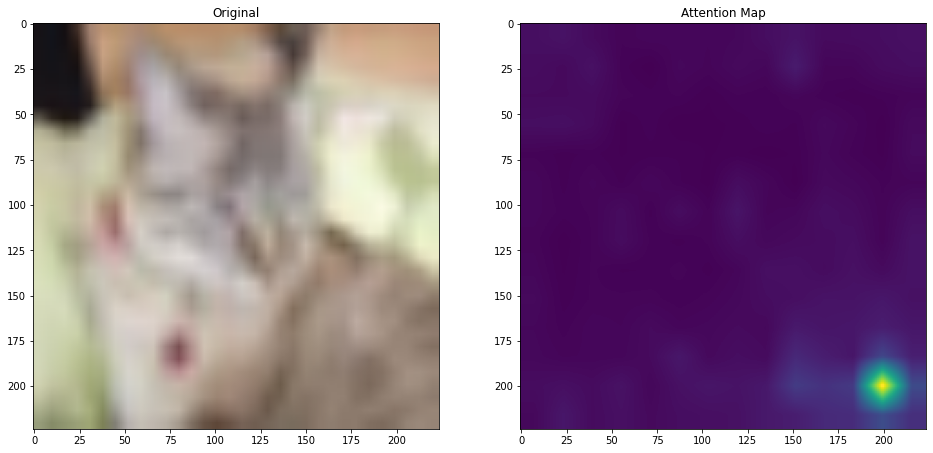

In [45]:
model = model.cpu()
model.eval()

logits, inter_logits, att_mat, new_att_mat = model(test_data[0][8].unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]


grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(mask)

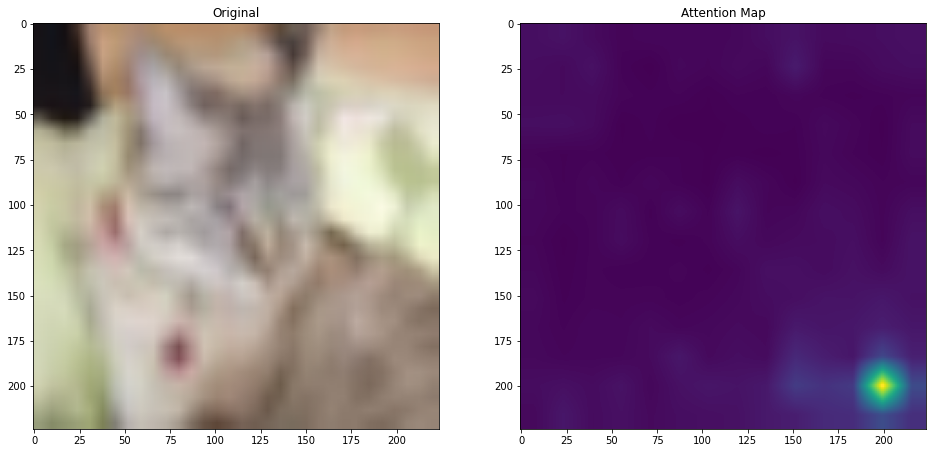

In [46]:
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
avg_v = torch.mean(v, dim = 0)
mask = avg_v[1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(mask)

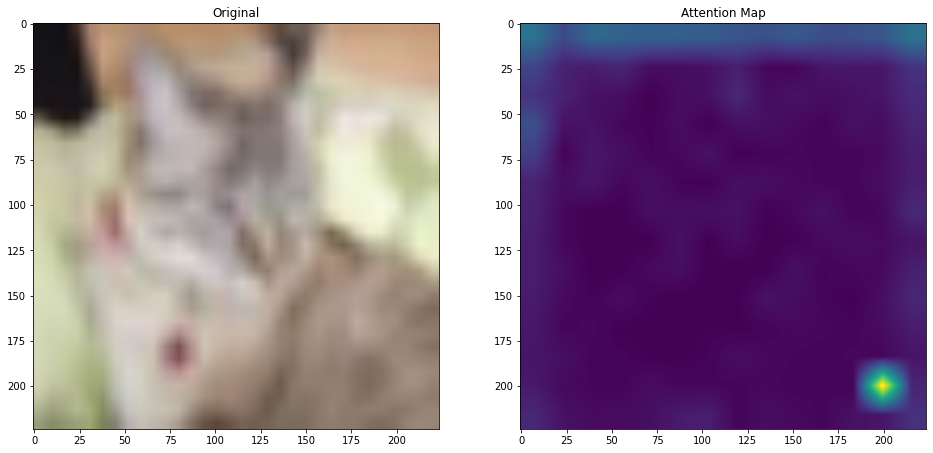

In [47]:
new_att_mat = new_att_mat.squeeze(0)
avg_new_att_mat = torch.mean(new_att_mat, dim = 0)
new_mask = avg_new_att_mat.reshape(grid_size, grid_size).detach().numpy()
new_mask = cv2.resize(new_mask / new_mask.max(), im.size)[..., np.newaxis]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(new_mask)

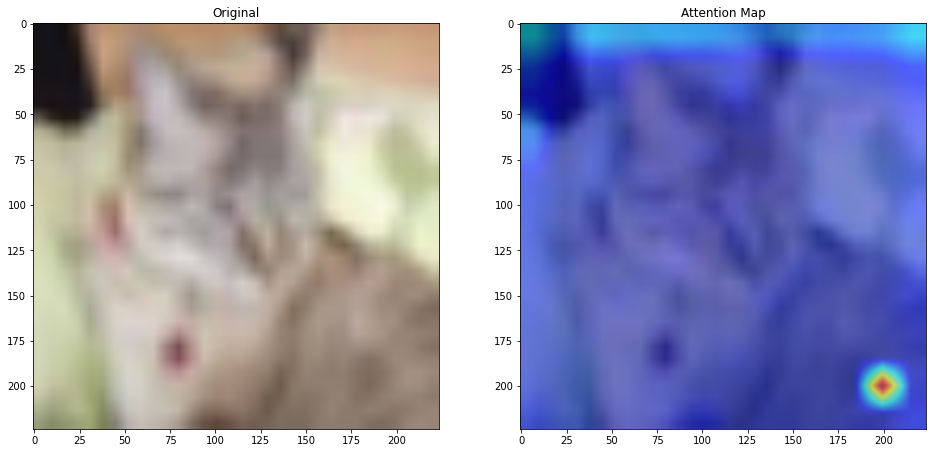

In [48]:
# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * new_mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) # / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

vis = show_cam_on_image(im, mask)
vis =  np.uint8(255 * vis)
vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(vis)

In [49]:
class CausalMetric():

    def __init__(self, model, mode, step, substrate_fn):
        r"""Create deletion/insertion metric instance.
        Args:
            model (nn.Module): Black-box model being explained.
            mode (str): 'del' or 'ins'.
            step (int): number of pixels modified per one iteration.
            substrate_fn (func): a mapping from old pixels to new pixels.
        """
        assert mode in ['del', 'ins']
        self.model = model
        self.mode = mode
        self.step = step
        self.substrate_fn = substrate_fn
        self.sm = torch.nn.Softmax(dim=-1)
        
    def single_run(self, img_tensor, label, explanation):
        r"""Run metric on one image-saliency pair.
        Args:
            img_tensor (Tensor): normalized image tensor.
            explanation (np.ndarray): saliency map.
            verbose (int): in [0, 1, 2].
                0 - return list of scores.
                1 - also plot final step.
                2 - also plot every step and print 2 top classes.
            save_to (str): directory to save every step plots to.
        Return:
            scores (nd.array): Array containing scores at every step.
        """
        n_steps = (HW + self.step - 1) // self.step

        if self.mode == 'del':
            title = 'Deletion game'
            ylabel = 'Pixels deleted'
            start = img_tensor.clone()
            finish = self.substrate_fn(img_tensor)
            finish = finish.cpu().numpy()
            
        elif self.mode == 'ins':
            title = 'Insertion game'
            ylabel = 'Pixels inserted'
            start = self.substrate_fn(img_tensor).cuda()
            finish = img_tensor.clone()
            finish = finish.cpu().numpy()
            
        scores = np.empty(n_steps + 1)
        # Coordinates of pixels in order of decreasing saliency
        salient_order = np.flip(np.argsort(explanation.reshape(-1, HW), axis=1), axis=-1)
        for i in range(n_steps+1):
            pred, _, _ , _ = self.model(start.unsqueeze(0))
            scores[i] = self.sm(pred)[0, label]
            
            if i < n_steps:
                start = start.cpu().numpy()
                coords = salient_order[:, self.step * i:self.step * (i + 1)]
                start.reshape(1, 3, HW)[0, :, coords] = finish.reshape(1, 3, HW)[0, :, coords]
                start = torch.from_numpy(start).cuda()
                
        return scores

In [51]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, RandomSampler, DistributedSampler, SequentialSampler

In [52]:
def get_dataset(args):
    if args.local_rank not in [-1, 0]:
        torch.distributed.barrier()

    transform_train = transforms.Compose([
        transforms.RandomResizedCrop((args.img_size, args.img_size), scale=(0.05, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    transform_test = transforms.Compose([
        transforms.Resize((args.img_size, args.img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    if args.dataset == "cifar10":
        trainset = datasets.CIFAR10(root="./data",
                                    train=True,
                                    download=True,
                                    transform=transform_train)
        testset = datasets.CIFAR10(root="./data",
                                   train=False,
                                   download=True,
                                   transform=transform_test) if args.local_rank in [-1, 0] else None

    else:
        trainset = datasets.CIFAR100(root="./data",
                                     train=True,
                                     download=True,
                                     transform=transform_train)
        testset = datasets.CIFAR100(root="./data",
                                    train=False,
                                    download=True,
                                    transform=transform_test) if args.local_rank in [-1, 0] else None

    return trainset, testset

In [53]:
trainset, testset = get_dataset(args)

Files already downloaded and verified
Files already downloaded and verified


In [54]:
subset = list(range(0, 200, 1))
test_set = torch.utils.data.Subset(testset, subset)

In [55]:
test_sampler = SequentialSampler(test_set)
test_loader = DataLoader(test_set,
                         sampler=test_sampler,
                         batch_size=args.eval_batch_size,
                         num_workers=4,
                        pin_memory=True) if testset is not None else None

In [ ]:
model = model.cuda()
model.eval()
scores = {'del': [], 'ins': []}
deletion = CausalMetric(model, 'del', 224, substrate_fn=torch.zeros_like)
insertion = CausalMetric(model, 'ins', 224, substrate_fn=torch.zeros_like)
HW = 224 * 224

In [56]:
with torch.no_grad():
    for step, batch in enumerate(tqdm(test_loader)):
        print("step:{}".format(step))
        x, y = batch
        for image,label in zip(x, y):
            image = image.cuda()
            label = label.numpy()
            logits, _,  _, new_att_mat = model(image.unsqueeze(0))

            new_att_mat = new_att_mat.squeeze(0)
            avg_new_att_mat = torch.mean(new_att_mat, dim = 0)
            new_mask = avg_new_att_mat.reshape(grid_size, grid_size).cpu().detach().numpy()
            new_mask = cv2.resize(new_mask / new_mask.max(), im.size)[..., np.newaxis]

            del_score = deletion.single_run(image, label, new_mask)
            print("del_score:{}".format(del_score.mean()))
            # scores['del'].append(del_score.mean())
            scores['del'].append(del_score)
            ins_score = insertion.single_run(image, label, new_mask)
            print("ins_score:{}".format(ins_score.mean()))
            # scores['ins'].append(ins_score.mean())
            scores['ins'].append(ins_score)

  0%|                                                                                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

step:0
del_score:0.5716451386838324
ins_score:0.5215598798791568
del_score:0.12736015079749954
ins_score:0.24270015722968513
del_score:0.12066351552079949
ins_score:0.14371842581778765
del_score:0.7880994616148786
ins_score:0.7936859315633774
del_score:0.679132826609744
ins_score:0.888387166576253
del_score:0.3109590926145514
ins_score:0.45617671043198144
del_score:0.21062338841251202
ins_score:0.6967257038214141
del_score:0.41411049427671565
ins_score:0.8961072079754538
del_score:0.52262477391089
ins_score:0.6128263291054302
del_score:0.24454291463674357
ins_score:0.5134552713421484
del_score:0.8779324203067356
ins_score:0.8321531515982415
del_score:0.6729708922116293
ins_score:0.7277601529844105
del_score:0.2413489668881003
ins_score:0.5540524656491147
del_score:0.2886738724592659
ins_score:0.713201734053178
del_score:0.6349049222034713
ins_score:0.6170731788439056
del_score:0.21988095152191817
ins_score:0.23569019870625602
del_score:0.3888471629884508
ins_score:0.707207483900711
del

 25%|████████████████████████████████████████████████████                                                                                                                                                            | 1/4 [02:30<07:31, 150.33s/it]

ins_score:0.3394534390502506
step:1
del_score:0.3316783473454416
ins_score:0.5027246885001659
del_score:0.34725589021626446
ins_score:0.6798107439941831
del_score:0.1299438411627327
ins_score:0.6012798884707606
del_score:0.34057448123685186
ins_score:0.497180035572706
del_score:0.20869378792328966
ins_score:0.42398529573033256
del_score:0.31869568826216793
ins_score:0.8105261288169358
del_score:0.2549916886476179
ins_score:0.5053953589571433
del_score:0.14761337989022852
ins_score:0.5403789153405362
del_score:0.4081213924092137
ins_score:0.46014937413442464
del_score:0.5340806673612032
ins_score:0.6592719420459535
del_score:0.5303825150802731
ins_score:0.7269696339343985
del_score:0.3939440835888187
ins_score:0.793767092741198
del_score:0.20322006974162327
ins_score:0.2973990442728003
del_score:0.6260205418306093
ins_score:0.5991234696822034
del_score:0.3044870202574465
ins_score:0.7090147664149602
del_score:0.1886169488210645
ins_score:0.35068734836661153
del_score:0.32999547329006923

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 2/4 [05:01<05:01, 150.65s/it]

ins_score:0.5982347873515553
step:2
del_score:0.11105709774367925
ins_score:0.3301543933298025
del_score:0.11228275573191543
ins_score:0.4752799567745791
del_score:0.17434301180558073
ins_score:0.676688765515056
del_score:0.4725677282508049
ins_score:0.5759295439554586
del_score:0.27393088297711476
ins_score:0.5211523595783446
del_score:0.49129934382314483
ins_score:0.6905414630927973
del_score:0.1642300435424032
ins_score:0.5433692583721131
del_score:0.4287677466476129
ins_score:0.6226662949969372
del_score:0.49739561906045615
ins_score:0.6422835082829826
del_score:0.24699772391364805
ins_score:0.4096037942129705
del_score:0.37171997037198806
ins_score:0.8155853911572033
del_score:0.23102310429016748
ins_score:0.45653977080765695
del_score:0.3142154239656197
ins_score:0.5714319250981013
del_score:0.3478491566531981
ins_score:0.541318105376429
del_score:0.28048327280622387
ins_score:0.3808462832081649
del_score:0.522494697045121
ins_score:0.49490033416284457
del_score:0.236026925691920

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 3/4 [07:32<02:30, 150.89s/it]

ins_score:0.4579631458574699
step:3
del_score:0.9013446314467324
ins_score:0.9118359831968943
del_score:0.1458199424446664
ins_score:0.7236052552755509
del_score:0.24109991276015838
ins_score:0.7155438593707125
del_score:0.3170780110100491
ins_score:0.6242842743111153
del_score:0.2542820799940576
ins_score:0.6809111093046765
del_score:0.1016937092740813
ins_score:0.1734908718077673
del_score:0.21790751264947983
ins_score:0.41109649379634194
del_score:0.20577962626392643


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:51<00:00, 117.84s/it]

ins_score:0.2950337507782711


In [57]:
del_scores = np.array(scores['del'])
ins_scores = np.array(scores['ins'])

In [58]:
print(round(del_scores.mean(),4))
print(round(ins_scores.mean(),4))

0.3479
0.5782


In [59]:
Delet_path = 'results/cifar10_inter_Del.npy'
Insert_path = 'results/cifar10_inter_Ins.npy'

In [60]:
np.save(Delet_path, del_scores)
np.save(Insert_path, ins_scores)